# Cu₃VS₄ Nanoparticle Synthesis - DoE Analysis

Design of Experiments analysis for Cu₃VS₄ nanoparticle synthesis optimization.

## Imports and Configuration

In [146]:
# Standard library
import warnings
from itertools import combinations, product

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Statistics and modeling
from scipy import stats
from scipy.stats import f as f_dist, norm, shapiro, jarque_bera, gaussian_kde, pearsonr
from scipy.optimize import differential_evolution, minimize
from scipy.interpolate import Rbf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.nonparametric.smoothers_lowess import lowess

# Machine learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Suppress warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ All imports successful")

✓ All imports successful


In [147]:
# Configuration - Update these paths to your locations
DATA_PATH = "/Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Data/COMPLETE_CUVS_DATA_SIDE2.csv"
OUTPUT_PATH = "/Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs"

# Create output directory if it doesn't exist
import os
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Helper function to save figures
def save_figure(fig, filename, dpi=300):
    """Save figure to OUTPUT_PATH."""
    filepath = os.path.join(OUTPUT_PATH, filename)
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {filepath}")

# Factor definitions
FACTORS = ['Temp', 'Time', 'VOacac', 'DDT', 'OAm']
RESPONSES = ['Squareness', 'Size', 'GSD']

# Factor bounds for screening design
FACTOR_BOUNDS = {
    'Temp': (260, 310),
    'Time': (8, 90),
    'VOacac': (0.08, 0.66),
    'DDT': (1, 5),
    'OAm': (1, 7)
}

print(f"✓ Configuration loaded")
print(f"  Data path: {DATA_PATH}")
print(f"  Output path: {OUTPUT_PATH}")

✓ Configuration loaded
  Data path: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Data/COMPLETE_CUVS_DATA_SIDE2.csv
  Output path: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs


## Generating The Initial Screening Design

In [148]:
def generate_screening_design():
    """
    Generate a half-fractional factorial screening design with center points.
    Uses ABCD = E as the defining relation.
    """
    # Step 1: Half-fractional factorial design (ABCD = E)
    base_design = list(product([-1, 1], repeat=4))  # A, B, C, D
    design_matrix = []

    for row in base_design:
        a, b, c, d = row
        e = a * b * c * d  # E = ABCD
        design_matrix.append([a, b, c, d, e])

    ff_design = pd.DataFrame(design_matrix, columns=["Temp", "Time", "VOacac", "DDT", "OAm"])

    # Step 2: Add 4 center points (all factors = 0)
    center_point = {"Temp": 0, "Time": 0, "VOacac": 0, "DDT": 0, "OAm": 0}
    center_df = pd.DataFrame([center_point] * 4)

    # Combine factorial and center points
    full_design = pd.concat([ff_design, center_df], ignore_index=True)

    # Step 3: Scale coded values to real-world synthesis ranges
    for factor, (low, high) in FACTOR_BOUNDS.items():
        full_design[factor] = np.interp(full_design[factor], [-1, 1], [low, high])

    return full_design


# Generate design
screening_df = generate_screening_design()
screening_df["Run_ID"] = range(1, len(screening_df) + 1)

# Add placeholders for lab results
screening_df["GSD"] = np.nan
screening_df["Squareness"] = np.nan
screening_df["Size"] = np.nan
screening_df["PhasePure"] = np.nan
screening_df["HasProduct"] = np.nan
screening_df["Polymorph"] = np.nan

print(f"Generated screening design with {len(screening_df)} runs")
display(screening_df.head(10))

Generated screening design with 20 runs


,Temp,Time,VOacac,DDT,OAm,Run_ID,GSD,Squareness,Size,PhasePure,HasProduct,Polymorph
0,260.0,8.0,0.08,1.0,7.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,260.0,8.0,0.08,5.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN
2,260.0,8.0,0.66,1.0,1.0,3,NaN,NaN,NaN,NaN,NaN,NaN
3,260.0,8.0,0.66,5.0,7.0,4,NaN,NaN,NaN,NaN,NaN,NaN
4,260.0,90.0,0.08,1.0,1.0,5,NaN,NaN,NaN,NaN,NaN,NaN
5,260.0,90.0,0.08,5.0,7.0,6,NaN,NaN,NaN,NaN,NaN,NaN
6,260.0,90.0,0.66,1.0,7.0,7,NaN,NaN,NaN,NaN,NaN,NaN
7,260.0,90.0,0.66,5.0,1.0,8,NaN,NaN,NaN,NaN,NaN,NaN
8,310.0,8.0,0.08,1.0,1.0,9,NaN,NaN,NaN,NaN,NaN,NaN
9,310.0,8.0,0.08,5.0,7.0,10,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# Export design to CSV (uncomment to save)
# screening_df.to_csv(os.path.join(OUTPUT_PATH, "Cu3VS4_Screening_Design.csv"), index=False)
# print(f"✓ Design saved to {OUTPUT_PATH}/Cu3VS4_Screening_Design.csv")

## Load Screening Results

In [150]:
# Load experimental data
df = pd.read_csv(DATA_PATH)
print(f"✓ Data loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns)}")
display(df.head())

✓ Data loaded: 41 rows, 12 columns

Columns: ['Temp', 'Time', 'VOacac', 'DDT', 'OAm', 'Run_ID', 'GSD', 'Squareness', 'Size', 'PhasePure', 'HasProduct', 'Polymorph']


,Temp,Time,VOacac,DDT,OAm,Run_ID,GSD,Squareness,Size,PhasePure,HasProduct,Polymorph
0,260,8,0.08,1.0,7.0,1,NaN,NaN,NaN,0,0,NaN
1,260,8,0.08,5.0,1.0,2,NaN,NaN,NaN,0,0,NaN
2,260,8,0.66,1.0,1.0,3,NaN,NaN,NaN,0,0,NaN
3,260,8,0.66,5.0,7.0,4,NaN,NaN,NaN,0,0,NaN
4,260,90,0.08,1.0,1.0,5,1.7058,0.502,11.241,0,1,cubic


## Two-Step ANOVA Analysis

In [151]:
class Cu3VS4_ANOVA_Analyzer_WithInteractions:
    """
    Analyzes Cu3VS4 screening design using ANOVA F-statistics.
    Includes two-way interactions for comprehensive factor screening.
    """

    def __init__(self, data, factors, response, filter_cubic=True):
        self.raw_data = data.copy()
        self.factors = factors
        self.response = response
        self.filter_cubic = filter_cubic
        self.data = None
        self.coded_data = None
        self.model = None
        self.anova_table = None
        self.effects_table = None
        self._prepare_data()

    def _prepare_data(self):
        """Filter and prepare data for analysis."""
        data = self.raw_data.copy()

        # Filter to cubic polymorph if requested
        if self.filter_cubic and 'Polymorph' in data.columns:
            data = data[(data['HasProduct'] == 1) & (data['Polymorph'] == 'cubic')].copy()
            print(f"Filtered to cubic polymorph: {len(data)} samples")

        # Drop rows with missing response
        data = data.dropna(subset=[self.response] + self.factors)
        self.data = data.reset_index(drop=True)

        # Create coded data
        self._code_factors()

    def _code_factors(self):
        """Code factors to [-1, +1] range."""
        self.coded_data = self.data.copy()

        print("\nCoding factors to [-1, +1]:")
        for factor in self.factors:
            low = self.data[factor].min()
            high = self.data[factor].max()
            self.coded_data[factor] = 2 * (self.data[factor] - low) / (high - low) - 1
            print(f"  {factor}: [{low:.4f}, {high:.4f}] → [-1, +1]")

    def fit_model(self, alpha=0.05):
        """Fit OLS model with main effects and two-way interactions."""
        formula = f"{self.response} ~ ({' + '.join(self.factors)}) ** 2"
        print(f"\nFormula: {formula}")

        self.model = smf.ols(formula, data=self.coded_data).fit()

        # Get ANOVA table
        self.anova_table = anova_lm(self.model, typ=2)

        # Calculate statistics
        n = len(self.coded_data)
        p = len(self.model.params)
        df_resid = self.anova_table.loc['Residual', 'df']

        print(f"\nDegrees of freedom: {df_resid} (n={n}, parameters={p})")
        print(f"F-critical value: {f_dist.ppf(1-alpha, 1, df_resid):.3f} (α={alpha}, df1=1, df2={df_resid})")
        print(f"Model fitted: R² = {self.model.rsquared:.4f}, Adj R² = {self.model.rsquared_adj:.4f}")

        # Create effects table
        self._create_effects_table(alpha)

        return self.model

    def _create_effects_table(self, alpha=0.05):
        """Create sorted effects table with significance flags."""
        effects = []
        for term in self.anova_table.index:
            if term != 'Residual':
                f_stat = self.anova_table.loc[term, 'F']
                p_val = self.anova_table.loc[term, 'PR(>F)']
                sum_sq = self.anova_table.loc[term, 'sum_sq']
                df = self.anova_table.loc[term, 'df']

                effects.append({
                    'Term': term,
                    'F-statistic': f_stat,
                    'p-value': p_val,
                    'df': int(df),
                    'Sum_Sq': sum_sq,
                    'Significant': 'Yes' if p_val < alpha else 'No'
                })

        self.effects_table = pd.DataFrame(effects).sort_values('F-statistic', ascending=False)

    def print_results(self, alpha=0.05):
        """Print comprehensive analysis results."""
        print("\n" + "="*80)
        print(f"Cu₃VS₄ SCREENING ANALYSIS (ANOVA WITH INTERACTIONS): {self.response}")
        print("="*80)
        print(f"Samples: {len(self.coded_data)}")
        print(f"Factors: {len(self.factors)}")
        print(f"Model: Main effects + Two-way interactions")
        print(f"Significance level: α = {alpha}")

        print("\n" + "-"*80)
        print("MODEL STATISTICS")
        print("-"*80)
        print(f"R²:                 {self.model.rsquared:.4f}")
        print(f"Adjusted R²:        {self.model.rsquared_adj:.4f}")
        print(f"Standard Error:     {np.sqrt(self.model.mse_resid):.4f}")
        print(f"Model F-statistic:  {self.model.fvalue:.2f} (p = {self.model.f_pvalue:.4f})")

        print("\n" + "-"*80)
        print("ANOVA TABLE (Type II)")
        print("-"*80)
        print(self.anova_table)

        print("\n" + "-"*80)
        print("EFFECTS TABLE (sorted by F-statistic)")
        print("-"*80)
        print(self.effects_table.to_string(index=False))

        sig_terms = self.effects_table[self.effects_table['Significant'] == 'Yes']
        print(f"\nSignificant terms (α={alpha}): {len(sig_terms)} out of {len(self.effects_table)}")

        if len(sig_terms) > 0:
            print("\nSignificant terms:")
            for _, row in sig_terms.iterrows():
                print(f"  {row['Term']:20s}: F={row['F-statistic']:6.2f}, p={row['p-value']:.4f}")

    def plot_pareto(self, ax=None, alpha=0.05):
        """Create Pareto chart of effects."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))

        effects = self.effects_table.copy()
        df_resid = self.anova_table.loc['Residual', 'df']
        f_crit = f_dist.ppf(1-alpha, 1, df_resid)

        colors = ['#2ecc71' if sig == 'Yes' else '#95a5a6' for sig in effects['Significant']]

        bars = ax.barh(range(len(effects)), effects['F-statistic'], color=colors, edgecolor='black')
        ax.axvline(x=f_crit, color='red', linestyle='--', linewidth=2, label=f'F-critical ({f_crit:.2f})')

        ax.set_yticks(range(len(effects)))
        ax.set_yticklabels(effects['Term'])
        ax.set_xlabel('F-statistic', fontweight='bold')
        ax.set_title(f'Pareto Chart: {self.response}', fontweight='bold')
        ax.legend()
        ax.invert_yaxis()

        return ax


print("✓ ANOVA Analyzer class defined")

✓ ANOVA Analyzer class defined



FACTOR SCREENING WITH ANOVA F-TESTS + INTERACTIONS (α = 0.05)

ANALYZING: Squareness
Filtered to cubic polymorph: 27 samples

Coding factors to [-1, +1]:
  Temp: [260.0000, 310.0000] → [-1, +1]
  Time: [8.0000, 90.0000] → [-1, +1]
  VOacac: [0.0800, 0.6600] → [-1, +1]
  DDT: [1.0000, 5.0000] → [-1, +1]
  OAm: [1.0000, 7.0000] → [-1, +1]

Formula: Squareness ~ (Temp + Time + VOacac + DDT + OAm) ** 2

Degrees of freedom: 11.0 (n=27, parameters=16)
F-critical value: 4.844 (α=0.05, df1=1, df2=11.0)
Model fitted: R² = 0.7893, Adj R² = 0.5020

Cu₃VS₄ SCREENING ANALYSIS (ANOVA WITH INTERACTIONS): Squareness
Samples: 27
Factors: 5
Model: Main effects + Two-way interactions
Significance level: α = 0.05

--------------------------------------------------------------------------------
MODEL STATISTICS
--------------------------------------------------------------------------------
R²:                 0.7893
Adjusted R²:        0.5020
Standard Error:     0.0323
Model F-statistic:  2.75 (p = 0.048

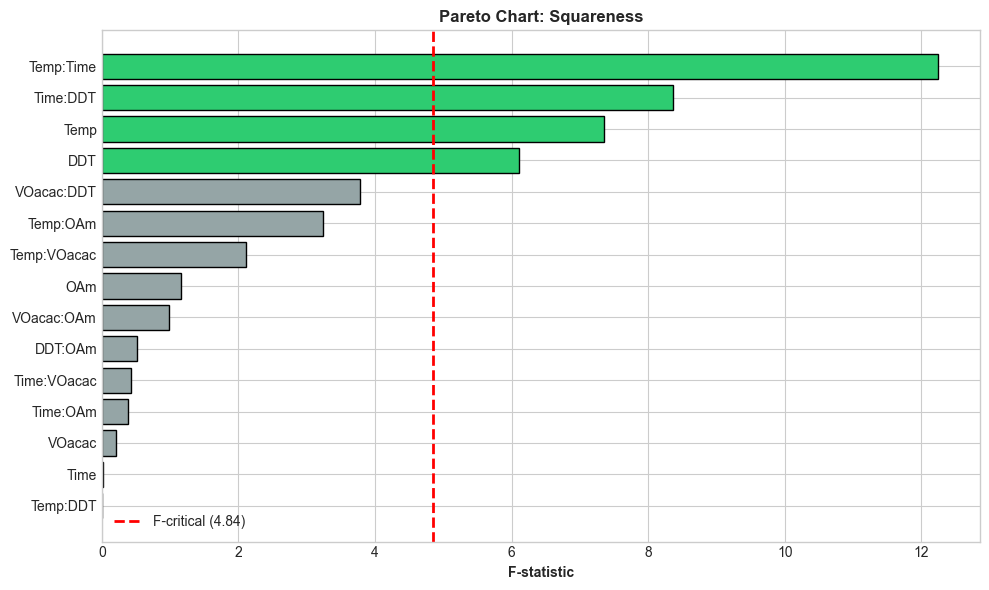


ANALYZING: Size
Filtered to cubic polymorph: 27 samples

Coding factors to [-1, +1]:
  Temp: [260.0000, 310.0000] → [-1, +1]
  Time: [8.0000, 90.0000] → [-1, +1]
  VOacac: [0.0800, 0.6600] → [-1, +1]
  DDT: [1.0000, 5.0000] → [-1, +1]
  OAm: [1.0000, 7.0000] → [-1, +1]

Formula: Size ~ (Temp + Time + VOacac + DDT + OAm) ** 2

Degrees of freedom: 11.0 (n=27, parameters=16)
F-critical value: 4.844 (α=0.05, df1=1, df2=11.0)
Model fitted: R² = 0.9059, Adj R² = 0.7775

Cu₃VS₄ SCREENING ANALYSIS (ANOVA WITH INTERACTIONS): Size
Samples: 27
Factors: 5
Model: Main effects + Two-way interactions
Significance level: α = 0.05

--------------------------------------------------------------------------------
MODEL STATISTICS
--------------------------------------------------------------------------------
R²:                 0.9059
Adjusted R²:        0.7775
Standard Error:     3.4348
Model F-statistic:  7.06 (p = 0.0012)

-----------------------------------------------------------------------------

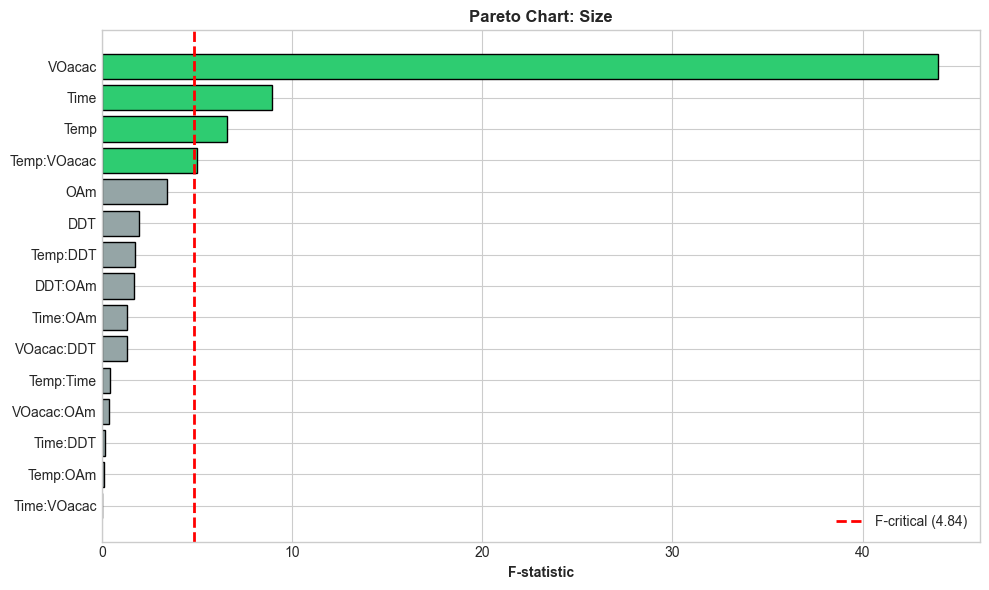


ANALYZING: GSD
Filtered to cubic polymorph: 27 samples

Coding factors to [-1, +1]:
  Temp: [260.0000, 310.0000] → [-1, +1]
  Time: [8.0000, 90.0000] → [-1, +1]
  VOacac: [0.0800, 0.6600] → [-1, +1]
  DDT: [1.0000, 5.0000] → [-1, +1]
  OAm: [1.0000, 7.0000] → [-1, +1]

Formula: GSD ~ (Temp + Time + VOacac + DDT + OAm) ** 2

Degrees of freedom: 11.0 (n=27, parameters=16)
F-critical value: 4.844 (α=0.05, df1=1, df2=11.0)
Model fitted: R² = 0.6672, Adj R² = 0.2134

Cu₃VS₄ SCREENING ANALYSIS (ANOVA WITH INTERACTIONS): GSD
Samples: 27
Factors: 5
Model: Main effects + Two-way interactions
Significance level: α = 0.05

--------------------------------------------------------------------------------
MODEL STATISTICS
--------------------------------------------------------------------------------
R²:                 0.6672
Adjusted R²:        0.2134
Standard Error:     0.1843
Model F-statistic:  1.47 (p = 0.2624)

--------------------------------------------------------------------------------

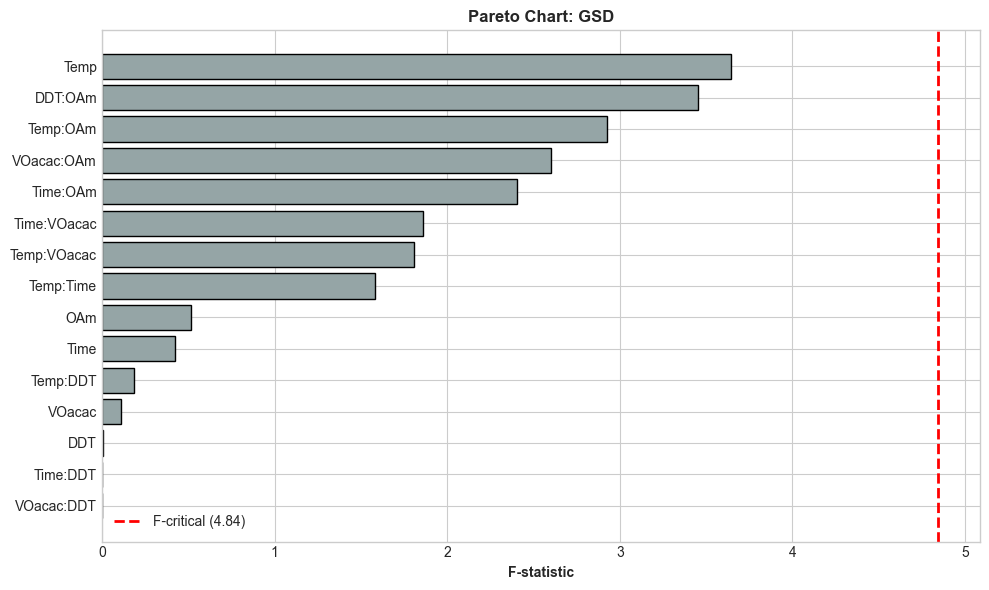

In [152]:
# Run ANOVA analysis for each response
print("\n" + "="*80)
print("FACTOR SCREENING WITH ANOVA F-TESTS + INTERACTIONS (α = 0.05)")
print("="*80)

results = {}
alpha = 0.05

for response in RESPONSES:
    print(f"\n{'='*80}")
    print(f"ANALYZING: {response}")
    print("="*80)

    analyzer = Cu3VS4_ANOVA_Analyzer_WithInteractions(
        data=df,
        factors=FACTORS,
        response=response,
        filter_cubic=True
    )

    analyzer.fit_model(alpha=alpha)
    analyzer.print_results(alpha=alpha)

    # Plot Pareto chart
    fig, ax = plt.subplots(figsize=(10, 6))
    analyzer.plot_pareto(ax=ax, alpha=alpha)
    plt.tight_layout()
    save_figure(fig, f'pareto_ANOVA_{response.lower()}.png')
    plt.show()

    results[response] = analyzer

In [153]:
# Summary of significant factors
print("\n" + "="*80)
print("FACTOR SELECTION SUMMARY")
print("="*80)

all_main_effects = set()
all_interactions = set()

for response, analyzer in results.items():
    sig = analyzer.effects_table[analyzer.effects_table['Significant'] == 'Yes']['Term'].tolist()
    main = [t for t in sig if ':' not in t]
    inter = [t for t in sig if ':' in t]

    print(f"\n{response}:")
    print(f"  Main effects: {main if main else 'None'}")
    print(f"  Interactions: {inter if inter else 'None'}")

    all_main_effects.update(main)
    all_interactions.update(inter)

# Get factors from interactions
factors_from_interactions = set()
for inter in all_interactions:
    factors_from_interactions.update(inter.split(':'))

recommended_factors = sorted(all_main_effects | factors_from_interactions)

print(f"\n{'='*80}")
print("CCD RECOMMENDATIONS")
print("="*80)
print(f"\nRecommended factors for CCD: {recommended_factors}")
print(f"Number of factors: {len(recommended_factors)}")


FACTOR SELECTION SUMMARY

Squareness:
  Main effects: ['Temp', 'DDT']
  Interactions: ['Temp:Time', 'Time:DDT']

Size:
  Main effects: ['VOacac', 'Time', 'Temp']
  Interactions: ['Temp:VOacac']

GSD:
  Main effects: None
  Interactions: None

CCD RECOMMENDATIONS

Recommended factors for CCD: ['DDT', 'Temp', 'Time', 'VOacac']
Number of factors: 4


## Multicollinearity Check


MULTICOLLINEARITY DIAGNOSTICS

--------------------------------------------------------------------------------
1. FACTOR CORRELATION MATRIX
--------------------------------------------------------------------------------
         Temp   Time  VOacac    DDT    OAm
Temp    1.000 -0.443   0.036 -0.157  0.051
Time   -0.443  1.000  -0.084 -0.139 -0.171
VOacac  0.036 -0.084   1.000  0.060  0.260
DDT    -0.157 -0.139   0.060  1.000  0.029
OAm     0.051 -0.171   0.260  0.029  1.000
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/correlation_matrix.png


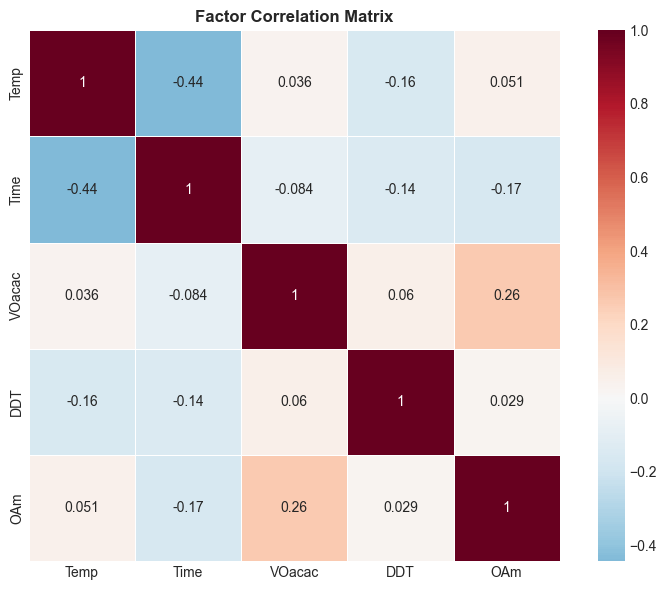


--------------------------------------------------------------------------------
2. VARIANCE INFLATION FACTORS (VIF)
--------------------------------------------------------------------------------
Rule of thumb: VIF > 5 suggests moderate, VIF > 10 suggests severe multicollinearity
Factor      VIF
  Time 1.352687
  Temp 1.325282
   OAm 1.099935
   DDT 1.088396
VOacac 1.077149

--------------------------------------------------------------------------------
3. CONDITION NUMBER
--------------------------------------------------------------------------------
Condition number: 1.83
  < 10: No concern
  10-30: Moderate concern
  > 30: Serious concern

ASSESSMENT
✓ VIF values acceptable
✓ Condition number acceptable


In [154]:
def check_multicollinearity(df, factor_columns, response_column):
    """Check for multicollinearity in the data."""
    print("\n" + "="*80)
    print("MULTICOLLINEARITY DIAGNOSTICS")
    print("="*80)

    # Filter data
    data = df.dropna(subset=factor_columns + [response_column]).copy()
    X = data[factor_columns]

    # 1. Correlation matrix
    print("\n" + "-"*80)
    print("1. FACTOR CORRELATION MATRIX")
    print("-"*80)
    corr_matrix = X.corr()
    print(corr_matrix.round(3))

    # Plot correlation heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, ax=ax)
    ax.set_title('Factor Correlation Matrix', fontweight='bold')
    plt.tight_layout()
    save_figure(fig, 'correlation_matrix.png')
    plt.show()

    # 2. VIF calculation
    print("\n" + "-"*80)
    print("2. VARIANCE INFLATION FACTORS (VIF)")
    print("-"*80)
    print("Rule of thumb: VIF > 5 suggests moderate, VIF > 10 suggests severe multicollinearity")

    X_const = add_constant(X)
    vif_data = pd.DataFrame({
        'Factor': factor_columns,
        'VIF': [variance_inflation_factor(X_const.values, i+1) for i in range(len(factor_columns))]
    })
    vif_data = vif_data.sort_values('VIF', ascending=False)
    print(vif_data.to_string(index=False))

    # 3. Condition number
    print("\n" + "-"*80)
    print("3. CONDITION NUMBER")
    print("-"*80)

    X_scaled = StandardScaler().fit_transform(X)
    eigenvalues = np.linalg.eigvals(np.corrcoef(X_scaled.T))
    condition_number = np.sqrt(np.max(eigenvalues) / np.min(np.abs(eigenvalues)))

    print(f"Condition number: {condition_number:.2f}")
    print("  < 10: No concern")
    print("  10-30: Moderate concern")
    print("  > 30: Serious concern")

    # Recommendations
    print("\n" + "="*80)
    print("ASSESSMENT")
    print("="*80)

    max_vif = vif_data['VIF'].max()
    if max_vif > 10:
        print("⚠️  High VIF detected - consider removing correlated factors")
    elif max_vif > 5:
        print("⚠️  Moderate VIF detected - proceed with caution")
    else:
        print("✓ VIF values acceptable")

    if condition_number > 30:
        print("⚠️  High condition number - serious multicollinearity concern")
    elif condition_number > 10:
        print("⚠️  Moderate condition number")
    else:
        print("✓ Condition number acceptable")

    return {'correlation_matrix': corr_matrix, 'vif': vif_data, 'condition_number': condition_number}


# Run multicollinearity check
mc_results = check_multicollinearity(df, FACTORS, 'GSD')

## OLS Regression Modeling

In [155]:
# Basic Model - Main Effects Only
print("="*80)
print("MAIN EFFECTS MODEL")
print("="*80)

model_main = smf.ols(formula="Squareness ~ Temp + Time + VOacac + DDT + OAm", data=df).fit()
print(model_main.summary())

MAIN EFFECTS MODEL
                            OLS Regression Results                            
Dep. Variable:             Squareness   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     4.293
Date:                Thu, 15 Jan 2026   Prob (F-statistic):            0.00589
Time:                        14:28:50   Log-Likelihood:                 53.349
No. Observations:                  31   AIC:                            -94.70
Df Residuals:                      25   BIC:                            -86.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3524      0.169 

In [156]:
# Full Model - With Interaction Effects
print("="*80)
print("FULL MODEL WITH INTERACTIONS")
print("="*80)

model_full = smf.ols("Squareness ~ (Temp + Time + VOacac + DDT + OAm)**2", data=df).fit()
print(model_full.summary())

FULL MODEL WITH INTERACTIONS
                            OLS Regression Results                            
Dep. Variable:             Squareness   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     2.921
Date:                Thu, 15 Jan 2026   Prob (F-statistic):             0.0230
Time:                        14:28:50   Log-Likelihood:                 64.918
No. Observations:                  31   AIC:                            -97.84
Df Residuals:                      15   BIC:                            -74.89
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.404

## Residual Diagnostics

✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/residual_diagnostics_squareness.png


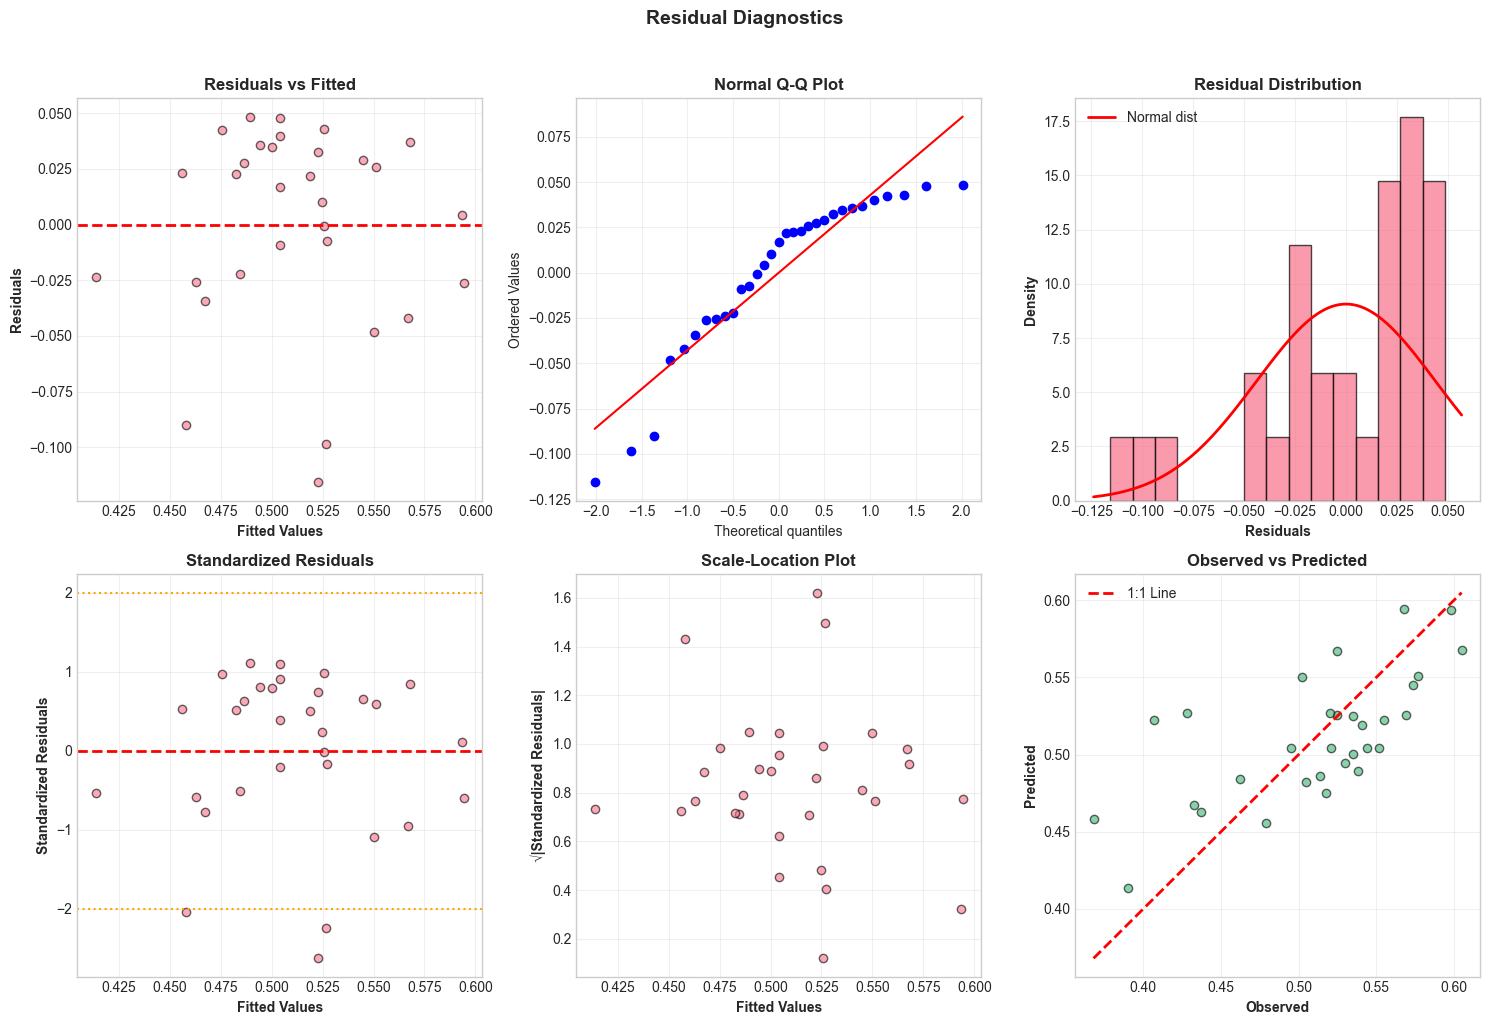


--------------------------------------------------
NORMALITY TESTS
--------------------------------------------------
Shapiro-Wilk:  W = 0.8746, p = 0.0018
Jarque-Bera:   JB = 6.7429, p = 0.0343
⚠️  Residuals may not be normally distributed (Shapiro-Wilk)


In [157]:
class ResidualDiagnostics:
    """Comprehensive residual diagnostics for regression models."""

    def __init__(self, model):
        self.model = model
        self.residuals = model.resid
        self.fitted = model.fittedvalues
        self.std_residuals = (self.residuals - self.residuals.mean()) / self.residuals.std()

    def plot_diagnostics(self):
        """Create comprehensive diagnostic plots."""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # 1. Residuals vs Fitted
        ax1 = axes[0, 0]
        ax1.scatter(self.fitted, self.residuals, alpha=0.6, edgecolors='k')
        ax1.axhline(0, color='red', linestyle='--', linewidth=2)
        ax1.set_xlabel('Fitted Values', fontweight='bold')
        ax1.set_ylabel('Residuals', fontweight='bold')
        ax1.set_title('Residuals vs Fitted', fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # 2. Q-Q Plot
        ax2 = axes[0, 1]
        stats.probplot(self.residuals, dist="norm", plot=ax2)
        ax2.set_title('Normal Q-Q Plot', fontweight='bold')
        ax2.grid(True, alpha=0.3)

        # 3. Histogram of Residuals
        ax3 = axes[0, 2]
        ax3.hist(self.residuals, bins=15, edgecolor='black', alpha=0.7, density=True)
        xmin, xmax = ax3.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        ax3.plot(x, stats.norm.pdf(x, self.residuals.mean(), self.residuals.std()),
                 'r-', linewidth=2, label='Normal dist')
        ax3.set_xlabel('Residuals', fontweight='bold')
        ax3.set_ylabel('Density', fontweight='bold')
        ax3.set_title('Residual Distribution', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Standardized Residuals
        ax4 = axes[1, 0]
        ax4.scatter(self.fitted, self.std_residuals, alpha=0.6, edgecolors='k')
        ax4.axhline(0, color='red', linestyle='--', linewidth=2)
        ax4.axhline(2, color='orange', linestyle=':', linewidth=1.5)
        ax4.axhline(-2, color='orange', linestyle=':', linewidth=1.5)
        ax4.set_xlabel('Fitted Values', fontweight='bold')
        ax4.set_ylabel('Standardized Residuals', fontweight='bold')
        ax4.set_title('Standardized Residuals', fontweight='bold')
        ax4.grid(True, alpha=0.3)

        # 5. Scale-Location Plot
        ax5 = axes[1, 1]
        ax5.scatter(self.fitted, np.sqrt(np.abs(self.std_residuals)), alpha=0.6, edgecolors='k')
        ax5.set_xlabel('Fitted Values', fontweight='bold')
        ax5.set_ylabel('√|Standardized Residuals|', fontweight='bold')
        ax5.set_title('Scale-Location Plot', fontweight='bold')
        ax5.grid(True, alpha=0.3)

        # 6. Observed vs Predicted
        ax6 = axes[1, 2]
        y_actual = self.model.model.endog
        ax6.scatter(y_actual, self.fitted, alpha=0.6, edgecolors='k', color='mediumseagreen')
        min_val = min(y_actual.min(), self.fitted.min())
        max_val = max(y_actual.max(), self.fitted.max())
        ax6.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')
        ax6.set_xlabel('Observed', fontweight='bold')
        ax6.set_ylabel('Predicted', fontweight='bold')
        ax6.set_title('Observed vs Predicted', fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        plt.suptitle('Residual Diagnostics', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        return fig

    def print_tests(self):
        """Print normality test results."""
        print("\n" + "-"*50)
        print("NORMALITY TESTS")
        print("-"*50)

        shapiro_stat, shapiro_p = shapiro(self.residuals)
        jb_stat, jb_p = jarque_bera(self.residuals)

        print(f"Shapiro-Wilk:  W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
        print(f"Jarque-Bera:   JB = {jb_stat:.4f}, p = {jb_p:.4f}")

        if shapiro_p > 0.05:
            print("✓ Residuals appear normally distributed (Shapiro-Wilk)")
        else:
            print("⚠️  Residuals may not be normally distributed (Shapiro-Wilk)")


# Run diagnostics on the main effects model
diag = ResidualDiagnostics(model_main)
fig = diag.plot_diagnostics()
save_figure(fig, 'residual_diagnostics_squareness.png')
plt.show()
diag.print_tests()

## Response Surface Visualization

In [158]:
# =============================================================================
# NOTE: All response surface visualization functions are now defined in Cell 24.
# This includes:
#   - get_top_features()
#   - create_smooth_cube_surface()
#   - generate_importance_based_response_surfaces()
# =============================================================================

# This cell is intentionally left blank - see Cell 24 for the function definitions.


# =============================================================================
# FUNCTION TO GET TOP 3 FEATURES FROM IMPORTANCE ANALYZER
# =============================================================================

def get_top_features(importance_analyzer, output_name, n_features=3):
    """
    Extract the top N most important features for a given output from the 
    importance analyzer results.
    
    Parameters
    ----------
    importance_analyzer : ImportanceAnalyzer
        The analyzer object containing results
    output_name : str
        The name of the output (as stored in results, e.g., 'Size (Cubic)', 
        'Polydispersity (Cubic)', etc.)
    n_features : int
        Number of top features to return (default: 3)
    
    Returns
    -------
    list : List of top feature names sorted by importance (highest first)
    """
    if output_name not in importance_analyzer.results:
        print(f"⚠ Warning: '{output_name}' not found in results.")
        print(f"  Available outputs: {list(importance_analyzer.results.keys())}")
        return None
    
    result = importance_analyzer.results[output_name]
    df_importance = result['dataframe']
    
    # Sort by ChiSquared (or Association for Cramér's V) in descending order
    # Handle infinite values by treating them as very large
    df_sorted = df_importance.copy()
    df_sorted['SortValue'] = df_sorted['ChiSquared'].replace([np.inf], 1e10)
    df_sorted = df_sorted.sort_values('SortValue', ascending=False)
    
    top_features = df_sorted['Feature'].head(n_features).tolist()
    
    print(f"  Top {n_features} features for {output_name}:")
    for i, feat in enumerate(top_features):
        row = df_sorted[df_sorted['Feature'] == feat].iloc[0]
        chi2 = row['ChiSquared']
        cramers = row['Association']
        chi2_str = "Inf" if np.isinf(chi2) else f"{chi2:.1f}"
        print(f"    {i+1}. {feat}: χ²={chi2_str}, V={cramers:.3f}")
    
    return top_features


# =============================================================================
# FUNCTION TO GENERATE RESPONSE SURFACES USING TOP FEATURES
# =============================================================================

def generate_importance_based_response_surfaces(df, importance_analyzer, 
                                                  output_mapping,
                                                  filter_cubic=True,
                                                  elev=25, azim=135, n_grid=40,
                                                  save_func=None,
                                                  custom_points=None):
    """
    Generate 4D response surface plots using the top 3 most important features
    from the chi-squared/Cramér's V analysis for each output variable.
    
    Parameters
    ----------
    df : DataFrame
        The full dataset
    importance_analyzer : ImportanceAnalyzer
        The analyzer object containing feature importance results
    output_mapping : dict
        Mapping from response column names to their full names in the analyzer.
        Example: {
            'Size': 'Size (Cubic)',
            'GSD': 'Polydispersity (Cubic)', 
            'Squareness': 'Squareness (Cubic)'
        }
    filter_cubic : bool
        Whether to filter to cubic polymorph only (default: True)
    elev, azim : float
        View angles for 3D plots
    n_grid : int
        Grid resolution
    save_func : callable, optional
        Function to save figures, e.g., save_figure(fig, filename)
    custom_points : dict, optional
        Dictionary mapping response names to lists of custom points to add.
        Example: {
            'Size': [(285, 3.0, 0.37), (290, 2.5, 0.40)],
            'GSD': [{'x': 280, 'y': 4.0, 'z': 0.35, 'label': 'Test Point'}]
        }
        Points are visual markers only and do NOT affect the response surface.
    
    Returns
    -------
    dict : Dictionary with response names as keys and (fig, ax, top_features) as values
    """
    print("="*70)
    print("GENERATING IMPORTANCE-BASED 4D RESPONSE SURFACES")
    print("="*70)
    
    # Filter data
    if filter_cubic:
        df_filtered = df[(df['HasProduct'] == 1) & (df['Polymorph'] == 'cubic')].copy()
        print(f"Using {len(df_filtered)} cubic samples")
    else:
        df_filtered = df[df['HasProduct'] == 1].copy()
        print(f"Using {len(df_filtered)} samples with product")
    
    results = {}
    
    for response_col, analyzer_name in output_mapping.items():
        print(f"\n{'-'*70}")
        print(f"Processing: {response_col} ({analyzer_name})")
        print(f"{'-'*70}")
        
        # Get top 3 features
        top_features = get_top_features(importance_analyzer, analyzer_name, n_features=3)
        
        if top_features is None:
            print(f"  ⚠ Skipping {response_col} - could not get feature importance")
            continue
        
        if len(top_features) < 3:
            print(f"  ⚠ Warning: Only {len(top_features)} features available")
            if len(top_features) < 3:
                print(f"  ⚠ Skipping {response_col} - need at least 3 features for cube")
                continue
        
        x_factor, y_factor, z_factor = top_features[0], top_features[1], top_features[2]
        
        print(f"\n  Creating cube with axes: {x_factor} × {y_factor} × {z_factor}")
        
        # Check if all required columns exist
        required_cols = [x_factor, y_factor, z_factor, response_col]
        missing_cols = [c for c in required_cols if c not in df_filtered.columns]
        if missing_cols:
            print(f"  ⚠ Missing columns: {missing_cols}. Skipping.")
            continue
        
        # Get custom points for this response (if provided)
        points_for_this_response = None
        if custom_points is not None:
            points_for_this_response = custom_points.get(response_col, None)
        
        # Create the response surface
        try:
            result = create_smooth_cube_surface(
                df_filtered,
                x_factor=x_factor,
                y_factor=y_factor,
                z_factor=z_factor,
                response=response_col,
                elev=elev,
                azim=azim,
                n_grid=n_grid,
                custom_points=points_for_this_response
            )
            # Handle both return formats (fig, ax) or (fig, ax, rbf)
            if len(result) == 3:
                fig, ax, rbf = result
            else:
                fig, ax = result
            
            # Save if function provided
            if save_func:
                filename = f'smooth_cube_{response_col}_importance_based.png'
                save_func(fig, filename)
            
            plt.show()
            
            results[response_col] = {
                'fig': fig,
                'ax': ax,
                'top_features': top_features,
                'x_factor': x_factor,
                'y_factor': y_factor,
                'z_factor': z_factor
            }
            
        except Exception as e:
            print(f"  ⚠ Error creating surface for {response_col}: {e}")
            continue
    
    print("\n" + "="*70)
    print("✓ IMPORTANCE-BASED RESPONSE SURFACES COMPLETE!")
    print("="*70)
    
    # Print summary
    print("\nSummary of generated surfaces:")
    for response_col, result in results.items():
        print(f"  {response_col}: {result['x_factor']} × {result['y_factor']} × {result['z_factor']}")
    
    return results


# =============================================================================
# EXAMPLE USAGE (add this to your notebook after the feature importance section)
# =============================================================================

USAGE_EXAMPLE = """
# =============================================================================
# USAGE EXAMPLE - Add this to your notebook after running feature importance
# =============================================================================

# Define the mapping from your response column names to the names used in 
# the importance analyzer results
OUTPUT_MAPPING = {
    'Size': 'Size (Cubic)',           # or whatever name appears in importance_analyzer.results
    'GSD': 'Polydispersity (Cubic)',
    'Squareness': 'Squareness (Cubic)'
}

# To see what names are available in your analyzer:
print("Available outputs in importance_analyzer.results:")
for name in importance_analyzer.results.keys():
    print(f"  - {name}")

# Generate response surfaces using top 3 features from importance analysis
results = generate_importance_based_response_surfaces(
    df=df,
    importance_analyzer=importance_analyzer,
    output_mapping=OUTPUT_MAPPING,
    filter_cubic=True,
    elev=25,
    azim=135,
    n_grid=40,
    save_func=save_figure  # or None if you don't want to save
)

# You can also manually create a surface with specific factors:
fig, ax = create_smooth_cube_surface(
    df_cubic,
    x_factor='Temp',
    y_factor='DDT', 
    z_factor='Time',
    response='Size',
    elev=25,
    azim=135
)
plt.show()
"""

if __name__ == "__main__":
    print("Response Surface with Importance-Based Feature Selection")
    print("="*60)
    print("\nThis module provides:")
    print("  1. create_smooth_cube_surface() - Customizable 4D cube function")
    print("  2. get_top_features() - Extract top N features from importance analysis")
    print("  3. generate_importance_based_response_surfaces() - Auto-generate surfaces")
    print("\n" + USAGE_EXAMPLE)

Response Surface with Importance-Based Feature Selection

This module provides:
  1. create_smooth_cube_surface() - Customizable 4D cube function
  2. get_top_features() - Extract top N features from importance analysis
  3. generate_importance_based_response_surfaces() - Auto-generate surfaces


# =============================================================================
# USAGE EXAMPLE - Add this to your notebook after running feature importance
# =============================================================================

# Define the mapping from your response column names to the names used in 
# the importance analyzer results
OUTPUT_MAPPING = {
    'Size': 'Size (Cubic)',           # or whatever name appears in importance_analyzer.results
    'GSD': 'Polydispersity (Cubic)',
    'Squareness': 'Squareness (Cubic)'
}

# To see what names are available in your analyzer:
print("Available outputs in importance_analyzer.results:")
for name in importance_analyzer.results.keys():
  

## Feature Importance Analysis

In [159]:
class ImportanceAnalyzer:
    """Analyzes feature importance using chi-squared tests with Cramér's V"""

    def __init__(self, dataframe, input_features, n_bins=5):
        self.df = dataframe
        self.input_features = input_features
        self.n_bins = n_bins
        self.results = {}

    def filter_data(self, output_col, filter_type=None, filter_value=None,
                   require_product=True, product_col='HasProduct'):
        """Filter data based on conditions."""
        df_filtered = self.df.copy()

        if require_product and product_col in df_filtered.columns:
            df_filtered = df_filtered[df_filtered[product_col] == 1]

        if filter_type and filter_value and filter_type in df_filtered.columns:
            df_filtered = df_filtered[df_filtered[filter_type] == filter_value]

        mask = ~(df_filtered[self.input_features].isna().any(axis=1) |
                 df_filtered[output_col].isna())
        df_filtered = df_filtered[mask]

        X = df_filtered[self.input_features]
        y = df_filtered[output_col]

        return X, y

    def discretize_features(self, X):
        """Bin continuous features into categories for chi-squared test."""
        from sklearn.preprocessing import KBinsDiscretizer
        
        X_binned = X.copy()

        for col in X.columns:
            n_unique = X[col].nunique()

            if n_unique <= 2:
                X_binned[col] = X[col]
            else:
                n_bins_actual = min(self.n_bins, n_unique)
                try:
                    discretizer = KBinsDiscretizer(
                        n_bins=n_bins_actual,
                        encode='ordinal',
                        strategy='quantile'
                    )
                    X_binned[col] = discretizer.fit_transform(X[[col]]).ravel()
                except:
                    X_binned[col] = pd.cut(X[col], bins=n_bins_actual, labels=False)

        return X_binned

    def discretize_target(self, y, n_bins=None):
        """Bin continuous target variable for chi-squared test."""
        from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
        
        if n_bins is None:
            n_bins = self.n_bins

        if y.dtype == 'object' or y.nunique() <= 10:
            if y.dtype == 'object':
                le = LabelEncoder()
                return le.fit_transform(y)
            return y.values

        n_unique = y.nunique()
        n_bins_actual = min(n_bins, n_unique)

        try:
            discretizer = KBinsDiscretizer(
                n_bins=n_bins_actual,
                encode='ordinal',
                strategy='quantile'
            )
            y_binned = discretizer.fit_transform(y.values.reshape(-1, 1)).ravel()
        except:
            y_binned = pd.cut(y, bins=n_bins_actual, labels=False).values

        return y_binned

    def calculate_chi_squared(self, X, y):
        """Calculate chi-squared scores and Cramér's V for each feature."""
        from scipy.stats import chi2_contingency
        
        if len(X) < 5:
            print(f"   ⚠ Warning: Only {len(X)} samples. Skipping.")
            return None, None, None, None

        X_binned = self.discretize_features(X)

        chi_scores = []
        p_values = []
        is_infinite = []
        association_strength = []

        for feature in X_binned.columns:
            contingency = pd.crosstab(X_binned[feature], y)
            chi2_stat, p_value, dof, expected = chi2_contingency(contingency)

            min_expected = expected.min()
            if min_expected < 0.01 or chi2_stat > 1e10:
                chi_scores.append(np.inf)
                is_infinite.append(True)
                cramers_v = 1.0
            else:
                chi_scores.append(chi2_stat)
                is_infinite.append(False)
                n = contingency.sum().sum()
                min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
                cramers_v = np.sqrt(chi2_stat / (n * min_dim)) if min_dim > 0 else 0
                cramers_v = min(cramers_v, 1.0)

            p_values.append(p_value)
            association_strength.append(cramers_v)

        return (np.array(chi_scores), np.array(p_values), 
                np.array(is_infinite), np.array(association_strength))

    def plot_importance_chart(self, chi_scores, p_values, is_infinite,
                             feature_names, title, color='#2E86AB',
                             association_strength=None):
        """Plot chi-squared scores with significance markers."""
        finite_mask = ~is_infinite
        finite_scores = chi_scores[finite_mask]
        finite_max = np.max(finite_scores) if len(finite_scores) > 0 else 1.0

        plot_scores = chi_scores.copy()
        plot_scores[is_infinite] = finite_max

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'ChiSquared': chi_scores,
            'PlotScore': plot_scores,
            'PValue': p_values,
            'IsInfinite': is_infinite,
            'Association': association_strength if association_strength is not None else np.zeros(len(feature_names))
        }).sort_values('PlotScore', ascending=True)

        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot bars
        for i, (idx, row) in enumerate(importance_df.iterrows()):
            if row['IsInfinite']:
                ax.barh(i, row['PlotScore'], color='#FF6B6B', alpha=0.8,
                       edgecolor='black', linewidth=1.5, hatch='///')
            else:
                ax.barh(i, row['PlotScore'], color=color, alpha=0.8,
                       edgecolor='black', linewidth=1.5)

        # Add value labels with significance stars
        for i, (idx, row) in enumerate(importance_df.iterrows()):
            if row['IsInfinite']:
                label_text = " Inf***"
            else:
                label_text = f" {row['ChiSquared']:.1f}"
                if row['PValue'] < 0.001:
                    label_text += "***"
                elif row['PValue'] < 0.01:
                    label_text += "**"
                elif row['PValue'] < 0.05:
                    label_text += "*"

            ax.text(row['PlotScore'], i, label_text,
                   va='center', ha='left', fontsize=11, fontweight='bold')

        ax.set_xlabel('Chi-Squared Score', fontsize=14, fontweight='bold')
        ax.set_title(f"{title}\n(* p<0.05, ** p<0.01, *** p<0.001)",
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_yticks(range(len(importance_df)))
        ax.set_yticklabels(importance_df['Feature'])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.tick_params(labelsize=12)
        ax.set_xlim(0, max(plot_scores) * 1.25)
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        plt.tight_layout()
        save_figure(fig, f'feature_importance_{title.lower().replace(" ", "_").replace("(", "").replace(")", "")}.png')
        plt.show()

        return importance_df

    def analyze_continuous_output(self, output_name, config):
        """Analyze continuous output using Chi-squared test."""
        print(f"\n{'='*70}")
        print(f"Analyzing: {config['full_name']} (Chi-squared)")
        print('='*70)

        filter_val = config.get('filter', None)
        if filter_val:
            X, y = self.filter_data(output_name, filter_type='Polymorph',
                                   filter_value=filter_val)
            print(f"Using {len(X)} samples (filtered to {filter_val})")
        else:
            X, y = self.filter_data(output_name, require_product=True)
            print(f"Using {len(X)} samples (all with product)")

        if len(X) < 5:
            print(f"   ⚠ Warning: Only {len(X)} samples. Skipping.")
            return

        y_binned = self.discretize_target(y)
        result = self.calculate_chi_squared(X, y_binned)

        if result[0] is None:
            return

        chi_scores, p_values, is_infinite, association_strength = result

        importance_df = self.plot_importance_chart(
            chi_scores, p_values, is_infinite,
            self.input_features, config['full_name'],
            color=config['color'],
            association_strength=association_strength
        )

        self.results[config['full_name']] = {
            'chi_squared': chi_scores,
            'p_values': p_values,
            'is_infinite': is_infinite,
            'association_strength': association_strength,
            'importances': association_strength,  # For heatmap compatibility
            'dataframe': importance_df,
            'n_samples': len(X),
            'method': 'Chi-squared'
        }

        print(f"\n✓ Chi-squared analysis complete")
        print(f"  Significant features (p < 0.05): {np.sum(p_values < 0.05)}/{len(p_values)}")

    def analyze_categorical_output(self, output_name, config):
        """Analyze categorical output using Chi-squared test."""
        print(f"\n{'='*70}")
        print(f"Analyzing: {config['full_name']} (Chi-squared)")
        print('='*70)

        filter_val = config.get('filter', None)
        if filter_val:
            X, y = self.filter_data(output_name, filter_type='Polymorph',
                                   filter_value=filter_val)
            print(f"Using {len(X)} samples (filtered to {filter_val})")
        else:
            X, y = self.filter_data(output_name, require_product=True)
            print(f"Using {len(X)} samples (all with product)")

        if len(X) < 5:
            print(f"   ⚠ Warning: Only {len(X)} samples. Skipping.")
            return

        if y.dtype == 'object':
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
        else:
            y_encoded = y.values

        result = self.calculate_chi_squared(X, y_encoded)

        if result[0] is None:
            return

        chi_scores, p_values, is_infinite, association_strength = result

        importance_df = self.plot_importance_chart(
            chi_scores, p_values, is_infinite,
            self.input_features, config['full_name'],
            color=config['color'],
            association_strength=association_strength
        )

        self.results[config['full_name']] = {
            'chi_squared': chi_scores,
            'p_values': p_values,
            'is_infinite': is_infinite,
            'association_strength': association_strength,
            'importances': association_strength,
            'dataframe': importance_df,
            'n_samples': len(X),
            'method': 'Chi-squared'
        }

        print(f"\n✓ Chi-squared analysis complete")
        print(f"  Significant features (p < 0.05): {np.sum(p_values < 0.05)}/{len(p_values)}")

    def analyze_product_formation(self, product_col='HasProduct'):
        """Analyze product formation using Chi-squared test."""
        print(f"\n{'='*70}")
        print(f"Analyzing: Product Formation (Chi-squared)")
        print('='*70)

        if product_col not in self.df.columns:
            print(f"⚠ Column '{product_col}' not found. Skipping.")
            return

        X = self.df[self.input_features]
        y = self.df[product_col]

        mask = ~(X.isna().any(axis=1) | y.isna())
        X = X[mask]
        y = y[mask]

        print(f"Using {len(X)} samples (all experiments)")

        if len(X) < 5:
            print(f"   ⚠ Warning: Only {len(X)} samples. Skipping.")
            return

        result = self.calculate_chi_squared(X, y.values)

        if result[0] is None:
            return

        chi_scores, p_values, is_infinite, association_strength = result

        importance_df = self.plot_importance_chart(
            chi_scores, p_values, is_infinite,
            self.input_features, 'Product Formation',
            color='#5D2E8C',
            association_strength=association_strength
        )

        self.results['Product Formation'] = {
            'chi_squared': chi_scores,
            'p_values': p_values,
            'is_infinite': is_infinite,
            'association_strength': association_strength,
            'importances': association_strength,
            'dataframe': importance_df,
            'n_samples': len(X),
            'method': 'Chi-squared'
        }

        print(f"\n✓ Chi-squared analysis complete")
        print(f"  Significant features (p < 0.05): {np.sum(p_values < 0.05)}/{len(p_values)}")

    def create_heatmap(self):
        """Create Cramér's V heatmap across all outputs."""
        print(f"\n{'='*70}")
        print("Creating Association Strength Heatmap (Cramér's V)")
        print('='*70)

        if not self.results:
            print("No results to plot")
            return

        association_dict = {}
        for output_name, result in self.results.items():
            association_dict[output_name] = result['association_strength']

        df_heatmap = pd.DataFrame(association_dict, index=self.input_features)

        fig, ax = plt.subplots(figsize=(12, 8))

        sns.heatmap(df_heatmap, annot=True, fmt='.3f', cmap='YlOrRd',
                   linewidths=2, linecolor='white',
                   cbar_kws={'shrink': 0.8},
                   vmin=0, vmax=1.0, ax=ax,
                   annot_kws={'size': 14, 'weight': 'bold'})
                   
        # Set colorbar label with custom font size
        cbar = ax.collections[0].colorbar
        cbar.set_label("Cramér's V", fontsize=14, fontweight='bold', rotation=270, labelpad=20)

        ax.set_xlabel('Output Variables', fontsize=20, fontweight='bold', labelpad=10)
        ax.set_ylabel('Synthesis Parameters', fontsize=20, fontweight='bold', labelpad=10)
        ax.set_title("Feature Association Strength (Cramér's V)", fontsize=24, fontweight='bold', pad=20)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=16)

        plt.tight_layout()
        save_figure(fig, 'feature_importance_heatmap.png')
        plt.show()

        print("✓ Heatmap displayed")
        return df_heatmap

    def create_summary_table(self):
        """Create summary table of top features for each output."""
        summary_data = []

        for output_name, result in self.results.items():
            df_sorted = result['dataframe'].sort_values('ChiSquared', ascending=False)
            row = {'Output': output_name, 'Method': 'Chi-squared'}

            for i in range(min(3, len(df_sorted))):
                feat = df_sorted.iloc[i]['Feature']
                chi2_val = df_sorted.iloc[i]['ChiSquared']
                p_val = df_sorted.iloc[i]['PValue']

                if np.isinf(chi2_val):
                    row[f'Top_{i+1}'] = f"{feat} (χ²=Inf***)"
                else:
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    row[f'Top_{i+1}'] = f"{feat} (χ²={chi2_val:.1f}{sig})"

            summary_data.append(row)

        summary_df = pd.DataFrame(summary_data)
        return summary_df


print("✓ ImportanceAnalyzer class defined (Chi-squared with Cramér's V)")

✓ ImportanceAnalyzer class defined (Chi-squared with Cramér's V)


In [160]:
# =============================================================================
# 4D RESPONSE SURFACE VISUALIZATION FUNCTIONS
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import Rbf
from matplotlib import cm

def get_top_features(importance_analyzer, output_name, n_features=3):
    """
    Extract the top N most important features for a given output from the 
    importance analyzer results based on chi-squared values.
    
    Parameters
    ----------
    importance_analyzer : ImportanceAnalyzer
        The analyzer object containing feature importance results
    output_name : str
        Name of the output variable in importance_analyzer.results
    n_features : int
        Number of top features to return (default: 3)
    
    Returns
    -------
    list : List of feature names, sorted by importance (highest first)
    """
    if output_name not in importance_analyzer.results:
        print(f"  ⚠ Warning: '{output_name}' not found in analyzer results")
        return None
    
    result = importance_analyzer.results[output_name]
    
    # Get the dataframe sorted by chi-squared value
    df_sorted = result['dataframe'].sort_values('ChiSquared', ascending=False)
    
    # Get top N features
    top_features = df_sorted.head(n_features)['Feature'].tolist()
    
    # Print information
    print(f"  Top {n_features} features for {output_name}:")
    for idx, (i, row) in enumerate(df_sorted.head(n_features).iterrows(), 1):
        feat = row['Feature']
        chi2 = row['ChiSquared']
        v = row.get('CramersV', np.nan)
        if np.isinf(chi2):
            print(f"    {idx}. {feat}: χ²=Inf, V={v:.3f}")
        else:
            print(f"    {idx}. {feat}: χ²={chi2:.1f}, V={v:.3f}")
    
    return top_features


def create_smooth_cube_surface(data, x_factor='OAm', y_factor='VOacac', z_factor='Temp',
                                response='Size', elev=30, azim=45,
                                figsize=(12, 9), n_grid=40,
                                x_label=None, y_label=None, z_label=None,
                                custom_points=None, points_on_top=False,
                                fontsize_title=14, fontsize_labels=12, fontsize_cbar=11, fontsize_point_labels=10):
    """
    Create a smooth continuous 3D cube surface where the 4th dimension (response)
    is encoded as color on the cube faces.
    
    Parameters
    ----------
    data : pd.DataFrame
        Data containing x_factor, y_factor, z_factor, and response columns
    x_factor, y_factor, z_factor : str
        Column names for the three axes
    response : str
        Column name for the response variable (will be color-coded)
    elev, azim : float
        Elevation and azimuth angles for 3D plot viewing
    figsize : tuple
        Figure size
    n_grid : int
        Grid resolution for interpolation
    x_label, y_label, z_label : str, optional
        Custom axis labels
    custom_points : list, optional
        List of custom points to mark on the plot. Can be:
        - List of tuples: [(x, y, z), ...]
        - List of dicts: [{'x': x, 'y': y, 'z': z, 'label': '...', ...}, ...]
    
    Returns
    -------
    fig, ax : matplotlib figure and axes
    """
    # Prepare data
    subset = data.dropna(subset=[x_factor, y_factor, z_factor, response])
    
    if len(subset) < 3:
        print(f"  ⚠ Insufficient data points ({len(subset)}) for surface creation")
        return None, None
    
    x_data = subset[x_factor].values
    y_data = subset[y_factor].values
    z_data = subset[z_factor].values
    response_data = subset[response].values
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Create interpolation function using RBF
    try:
        rbf = Rbf(x_data, y_data, z_data, response_data, function='multiquadric', smooth=0.1)
    except:
        rbf = Rbf(x_data, y_data, z_data, response_data, function='linear')
    
    # Define grid ranges
    x_min, x_max = x_data.min(), x_data.max()
    y_min, y_max = y_data.min(), y_data.max()
    z_min, z_max = z_data.min(), z_data.max()
    
    x_range = np.linspace(x_min, x_max, n_grid)
    y_range = np.linspace(y_min, y_max, n_grid)
    z_range = np.linspace(z_min, z_max, n_grid)
    
    # Normalize for cube coordinates (0 to 1)
    def normalize(val, vmin, vmax):
        return (val - vmin) / (vmax - vmin) if vmax > vmin else 0.5
    
    # Create cube boundaries
    cube_size = 1.0
    cube_center = [0.5, 0.5, 0.5]
    
    # Generate surfaces for each face of the cube
    faces = []
    face_colors = []
    
    # Front face (z = z_min)
    z_val = z_min
    X_front, Y_front = np.meshgrid(x_range, y_range)
    Z_front = np.full_like(X_front, z_val)
    R_front = np.array([[rbf(x, y, z_val) for x in x_range] for y in y_range])
    faces.append((X_front, Y_front, Z_front))
    face_colors.append(R_front)
    
    # Back face (z = z_max)
    z_val = z_max
    X_back, Y_back = np.meshgrid(x_range, y_range)
    Z_back = np.full_like(X_back, z_val)
    R_back = np.array([[rbf(x, y, z_val) for x in x_range] for y in y_range])
    faces.append((X_back, Y_back, Z_back))
    face_colors.append(R_back)
    
    # Left face (x = x_min)
    x_val = x_min
    Y_left, Z_left = np.meshgrid(y_range, z_range)
    X_left = np.full_like(Y_left, x_val)
    R_left = np.array([[rbf(x_val, y, z) for y in y_range] for z in z_range])
    faces.append((X_left, Y_left, Z_left))
    face_colors.append(R_left)
    
    # Right face (x = x_max)
    x_val = x_max
    Y_right, Z_right = np.meshgrid(y_range, z_range)
    X_right = np.full_like(Y_right, x_val)
    R_right = np.array([[rbf(x_val, y, z) for y in y_range] for z in z_range])
    faces.append((X_right, Y_right, Z_right))
    face_colors.append(R_right)
    
    # Bottom face (y = y_min)
    y_val = y_min
    X_bottom, Z_bottom = np.meshgrid(x_range, z_range)
    Y_bottom = np.full_like(X_bottom, y_val)
    R_bottom = np.array([[rbf(x, y_val, z) for x in x_range] for z in z_range])
    faces.append((X_bottom, Y_bottom, Z_bottom))
    face_colors.append(R_bottom)
    
    # Top face (y = y_max)
    y_val = y_max
    X_top, Z_top = np.meshgrid(x_range, z_range)
    Y_top = np.full_like(X_top, y_val)
    R_top = np.array([[rbf(x, y_val, z) for x in x_range] for z in z_range])
    faces.append((X_top, Y_top, Z_top))
    face_colors.append(R_top)
    
    # Normalize colors across all faces - get global min/max
    all_colors = np.concatenate([c.flatten() for c in face_colors])
    vmin, vmax = all_colors.min(), all_colors.max()
    
    # Helper function to normalize response values
    def normalize_response(resp):
        return (resp - vmin) / (vmax - vmin + 1e-10)
    
    # Face transparency
    face_alpha = 0.7
    
    # Prepare surface data (we'll plot surfaces AFTER points for correct layering)
    cmap = cm.get_cmap('viridis')
    
    # Front face (z = z_min)
    z_val = z_min
    X1, Y1 = np.meshgrid(x_range, y_range)
    Z1 = np.full_like(X1, z_val)
    RESP1 = R_front
    
    # Back face (z = z_max)
    z_val = z_max
    X2, Y2 = np.meshgrid(x_range, y_range)
    Z2 = np.full_like(X2, z_val)
    RESP2 = R_back
    
    # Right face (x = x_max)
    x_val = x_max
    Y3, Z3 = np.meshgrid(y_range, z_range)
    X3 = np.full_like(Y3, x_val)
    RESP3 = R_right
    
    # Left face (x = x_min)
    x_val = x_min
    Y4, Z4 = np.meshgrid(y_range, z_range)
    X4 = np.full_like(Y4, x_val)
    RESP4 = R_left
    
    # Top face (y = y_max)
    y_val = y_max
    X5, Z5 = np.meshgrid(x_range, z_range)
    Y5 = np.full_like(X5, y_val)
    RESP5 = R_top
    
    # Bottom face (y = y_min)
    y_val = y_min
    X6, Z6 = np.meshgrid(x_range, z_range)
    Y6 = np.full_like(X6, y_val)
    RESP6 = R_bottom
    
    # Set axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    # Default label mappings
    # Note: Using mathtext for subscripts (VO(acac)₂) to avoid rendering issues in 3D plots
    # Using \mathbf{} for bold math in subscript
    default_labels = {
        'Temp': 'Temperature (°C)',
        'Time': 'Time (min)',
        'VOacac': r'VO(acac)$_{\boldsymbol{2}}$ (mmol)',  # Use LaTeX subscript with bold formatting
        'CuI': 'CuI (mmol)',
        'DDT': 'DDT (mL)',
        'OAm': 'OAm (mL)',
        'OLAM': 'OLAM (mL)',
        'ODE': 'ODE (mL)',
        'Size': 'Size (nm)',
        'GSD': 'Polydispersity (%)',
        'Squareness': 'Shape (θ)'
    }
    
    # IMPORTANT: Plot order matters for 3D layering in matplotlib
    # Layering order (from back to front):
    #   1. Regular data points (zorder=1)
    #   2. Custom/predicted points (zorder=3) - on top of regular points
    #   3. Surfaces (zorder=5) - on top of all points
    # Control with points_on_top parameter:
    #   False (default): Surfaces on top of points (front faces visible over all points)
    #   True: Points on top of surfaces (all points visible over surfaces)
    
    if points_on_top:
        # Plot surfaces FIRST (so they're behind points)
        ax.plot_surface(X1, Y1, Z1, facecolors=cmap(normalize_response(RESP1)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=1)
        ax.contour(X1, Y1, Z1, RESP1, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=2)
        
        ax.plot_surface(X2, Y2, Z2, facecolors=cmap(normalize_response(RESP2)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=1)
        ax.contour(X2, Y2, Z2, RESP2, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=2)
        
        ax.plot_surface(X3, Y3, Z3, facecolors=cmap(normalize_response(RESP3)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=1)
        ax.contour(X3, Y3, Z3, RESP3, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=2)
        
        ax.plot_surface(X4, Y4, Z4, facecolors=cmap(normalize_response(RESP4)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=1)
        ax.contour(X4, Y4, Z4, RESP4, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=2)
        
        ax.plot_surface(X5, Y5, Z5, facecolors=cmap(normalize_response(RESP5)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=1)
        ax.contour(X5, Y5, Z5, RESP5, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=2)
        
        ax.plot_surface(X6, Y6, Z6, facecolors=cmap(normalize_response(RESP6)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=1)
        ax.contour(X6, Y6, Z6, RESP6, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=2)
        
        # Plot data points AFTER surfaces (so they're on top)
        scatter = ax.scatter(x_data, y_data, z_data, c=response_data, cmap='viridis',
                            s=200, edgecolors='black', linewidth=1.5, alpha=1, 
                            depthshade=False, zorder=10)
        
        # Add custom points AFTER surfaces (so they're on top)
        custom_point_artists = []
        if custom_points:
            for point in custom_points:
                if isinstance(point, tuple) and len(point) == 3:
                    x, y, z = point
                    label = None
                    marker = 'o'
                    size = 300
                    color = 'red'
                elif isinstance(point, dict):
                    x = point.get('x')
                    y = point.get('y')
                    z = point.get('z')
                    label = point.get('label')
                    marker = point.get('marker', 'o')
                    size = point.get('size', 300)
                    color = point.get('color', 'red')
                else:
                    continue
                
                try:
                    r_val = rbf(x, y, z)
                    custom_scatter = ax.scatter([x], [y], [z], c=[r_val], s=size, 
                              marker=marker, cmap='viridis', 
                              edgecolors='black', linewidths=2, 
                              alpha=1.0, zorder=11)
                    custom_point_artists.append(custom_scatter)
                    if label:
                        # Format the predicted value based on response type
                        if response == 'Size':
                            value_str = f'{r_val:.1f} nm'
                        elif response == 'GSD':
                            value_str = f'{r_val:.2f}%'
                        elif response == 'Squareness':
                            value_str = f'{r_val:.3f}'
                        else:
                            value_str = f'{r_val:.2f}'
                        
                        # Add value to label if it's a predicted point
                        if 'Predicted' in label or 'predicted' in label.lower():
                            label_text = f'{label}: {value_str}'
                        else:
                            label_text = label
                        ax.text(x, y, z, f'  {label_text}', fontsize=fontsize_point_labels, fontweight='bold', zorder=100)
                except:
                    custom_scatter = ax.scatter([x], [y], [z], c=color, s=size, marker=marker,
                              edgecolors='black', linewidths=2, alpha=1.0, zorder=11)
                    custom_point_artists.append(custom_scatter)
                    if label:
                        # If we couldn't get r_val, try to calculate it anyway for the label
                        try:
                            r_val = rbf(x, y, z)
                            # Format the predicted value based on response type
                            if response == 'Size':
                                value_str = f'{r_val:.1f} nm'
                            elif response == 'GSD':
                                value_str = f'{r_val:.2f}%'
                            elif response == 'Squareness':
                                value_str = f'{r_val:.3f}'
                            else:
                                value_str = f'{r_val:.2f}'
                            
                            # Add value to label if it's a predicted point
                            if 'Predicted' in label or 'predicted' in label.lower():
                                label_text = f'{label}: {value_str}'
                            else:
                                label_text = label
                        except:
                            label_text = label
                        ax.text(x, y, z, f'  {label_text}', fontsize=fontsize_point_labels, fontweight='bold', zorder=100)
    else:
        # DEFAULT: Layering order - Regular points → Custom points → Surfaces
        # Plot regular data points FIRST (lowest layer, zorder=1)
        scatter = ax.scatter(x_data, y_data, z_data, c=response_data, cmap='viridis',
                            s=200, edgecolors='black', linewidth=1.5, alpha=1, 
                            depthshade=False, zorder=1)
        
        # Add custom/predicted points AFTER regular points (middle layer, zorder=4)
        # These will be on top of regular points but below surfaces
        # Using zorder=4 (higher than regular points at 1, but lower than surfaces at 5)
        # and plotting AFTER regular points ensures they render on top
        custom_point_artists = []
        if custom_points:
            for point in custom_points:
                if isinstance(point, tuple) and len(point) == 3:
                    x, y, z = point
                    label = None
                    marker = 'o'
                    size = 300
                    color = 'red'
                elif isinstance(point, dict):
                    x = point.get('x')
                    y = point.get('y')
                    z = point.get('z')
                    label = point.get('label')
                    marker = point.get('marker', 'o')
                    size = point.get('size', 300)
                    color = point.get('color', 'red')
                else:
                    continue
                
                try:
                    r_val = rbf(x, y, z)
                    # Use higher zorder and ensure it's plotted after regular points
                    # Increase size slightly and use stronger edge to make it stand out
                    actual_size = max(size, 400) if marker == '*' else size  # Make stars larger
                    custom_scatter = ax.scatter([x], [y], [z], c=[r_val], s=actual_size, 
                              marker=marker, cmap='viridis', 
                              edgecolors='black', linewidths=3, 
                              alpha=1.0, zorder=4.5, depthshade=False)  # zorder=4.5: above regular (1) but below surfaces (5)
                    custom_point_artists.append(custom_scatter)
                    if label:
                        # Check if custom point dict has predicted value and uncertainty (from model)
                        predicted_value = point.get('predicted_value', None) if isinstance(point, dict) else None
                        predicted_std = point.get('predicted_std', None) if isinstance(point, dict) else None
                        
                        if predicted_value is not None:
                            # Use provided predicted value (from model)
                            r_val = predicted_value
                            if predicted_std is not None:
                                # Format with uncertainty
                                if response == 'Size':
                                    value_str = f'{r_val:.1f} ± {predicted_std:.1f} nm'
                                elif response == 'GSD':
                                    value_str = f'{r_val:.2f} ± {predicted_std:.2f}%'
                                elif response == 'Squareness':
                                    value_str = f'{r_val:.3f} ± {predicted_std:.3f}'
                                else:
                                    value_str = f'{r_val:.2f} ± {predicted_std:.2f}'
                            else:
                                # Format without uncertainty
                                if response == 'Size':
                                    value_str = f'{r_val:.1f} nm'
                                elif response == 'GSD':
                                    value_str = f'{r_val:.2f}%'
                                elif response == 'Squareness':
                                    value_str = f'{r_val:.3f}'
                                else:
                                    value_str = f'{r_val:.2f}'
                        else:
                            # Use RBF interpolated value
                            if response == 'Size':
                                value_str = f'{r_val:.1f} nm'
                            elif response == 'GSD':
                                value_str = f'{r_val:.2f}%'
                            elif response == 'Squareness':
                                value_str = f'{r_val:.3f}'
                            else:
                                value_str = f'{r_val:.2f}'
                        
                        # Add value to label if it's a predicted point
                        if 'Predicted' in label or 'predicted' in label.lower():
                            label_text = f'{label}: {value_str}'
                        else:
                            label_text = label
                        ax.text(x, y, z, f'  {label_text}', fontsize=fontsize_point_labels, fontweight='bold', zorder=100)
                except:
                    # Use higher zorder and ensure it's plotted after regular points
                    # Increase size slightly and use stronger edge to make it stand out
                    actual_size = max(size, 400) if marker == '*' else size  # Make stars larger
                    custom_scatter = ax.scatter([x], [y], [z], c=color, s=actual_size, marker=marker,
                              edgecolors='black', linewidths=3, alpha=1.0, zorder=4.5, depthshade=False)  # zorder=4.5: above regular (1) but below surfaces (5)
                    custom_point_artists.append(custom_scatter)
                    if label:
                        # Check if custom point dict has predicted value and uncertainty (from model)
                        predicted_value = point.get('predicted_value', None) if isinstance(point, dict) else None
                        predicted_std = point.get('predicted_std', None) if isinstance(point, dict) else None
                        
                        if predicted_value is not None:
                            # Use provided predicted value (from model)
                            r_val = predicted_value
                            if predicted_std is not None:
                                # Format with uncertainty
                                if response == 'Size':
                                    value_str = f'{r_val:.1f} ± {predicted_std:.1f} nm'
                                elif response == 'GSD':
                                    value_str = f'{r_val:.2f} ± {predicted_std:.2f}%'
                                elif response == 'Squareness':
                                    value_str = f'{r_val:.3f} ± {predicted_std:.3f}'
                                else:
                                    value_str = f'{r_val:.2f} ± {predicted_std:.2f}'
                            else:
                                # Format without uncertainty
                                if response == 'Size':
                                    value_str = f'{r_val:.1f} nm'
                                elif response == 'GSD':
                                    value_str = f'{r_val:.2f}%'
                                elif response == 'Squareness':
                                    value_str = f'{r_val:.3f}'
                                else:
                                    value_str = f'{r_val:.2f}'
                        else:
                            # If we couldn't get r_val, try to calculate it anyway for the label
                            try:
                                r_val = rbf(x, y, z)
                                # Format the predicted value based on response type
                                if response == 'Size':
                                    value_str = f'{r_val:.1f} nm'
                                elif response == 'GSD':
                                    value_str = f'{r_val:.2f}%'
                                elif response == 'Squareness':
                                    value_str = f'{r_val:.3f}'
                                else:
                                    value_str = f'{r_val:.2f}'
                            except:
                                value_str = None
                        
                        # Add value to label if it's a predicted point
                        if value_str is not None and ('Predicted' in label or 'predicted' in label.lower()):
                            label_text = f'{label}: {value_str}'
                        else:
                            label_text = label
                        ax.text(x, y, z, f'  {label_text}', fontsize=fontsize_point_labels, fontweight='bold', zorder=100)
        
        # Plot surfaces LAST (so they appear on top of points)
        # This ensures front faces layer correctly over all points
        ax.plot_surface(X1, Y1, Z1, facecolors=cmap(normalize_response(RESP1)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=5)
        ax.contour(X1, Y1, Z1, RESP1, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=6)
        
        ax.plot_surface(X2, Y2, Z2, facecolors=cmap(normalize_response(RESP2)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=5)
        ax.contour(X2, Y2, Z2, RESP2, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=6)
        
        ax.plot_surface(X3, Y3, Z3, facecolors=cmap(normalize_response(RESP3)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=5)
        ax.contour(X3, Y3, Z3, RESP3, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=6)
        
        ax.plot_surface(X4, Y4, Z4, facecolors=cmap(normalize_response(RESP4)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=5)
        ax.contour(X4, Y4, Z4, RESP4, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=6)
        
        ax.plot_surface(X5, Y5, Z5, facecolors=cmap(normalize_response(RESP5)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=5)
        ax.contour(X5, Y5, Z5, RESP5, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=6)
        
        ax.plot_surface(X6, Y6, Z6, facecolors=cmap(normalize_response(RESP6)),
                       alpha=face_alpha, antialiased=True, linewidth=0, shade=True, 
                       rcount=n_grid, ccount=n_grid, zorder=5)
        ax.contour(X6, Y6, Z6, RESP6, levels=12, colors='black', linewidths=0.6, alpha=0.4, zorder=6)
    
    # Set labels (with customizable font sizes)
    ax.set_xlabel(x_label or default_labels.get(x_factor, x_factor), 
                  fontsize=fontsize_labels, fontweight='bold', labelpad=10)
    ax.set_ylabel(y_label or default_labels.get(y_factor, y_factor), 
                  fontsize=fontsize_labels, fontweight='bold', labelpad=10)
    ax.set_zlabel(z_label or default_labels.get(z_factor, z_factor), 
                  fontsize=fontsize_labels, fontweight='bold', labelpad=10)
    
    # Remove background boxes from axis labels (if they exist)
    try:
        ax.xaxis.label.set_bbox(dict(boxstyle='none', facecolor='none', edgecolor='none'))
        ax.yaxis.label.set_bbox(dict(boxstyle='none', facecolor='none', edgecolor='none'))
        ax.zaxis.label.set_bbox(dict(boxstyle='none', facecolor='none', edgecolor='none'))
    except:
        # If that doesn't work, try setting bbox to None
        try:
            ax.xaxis.label.set_bbox(None)
            ax.yaxis.label.set_bbox(None)
            ax.zaxis.label.set_bbox(None)
        except:
            pass
    
    # Force the z-axis label to show
    ax.zaxis.set_rotate_label(False)
    ax.zaxis.label.set_rotation(90)
    ax.set_box_aspect(None, zoom=0.85)
    
    # Set view angle
    ax.view_init(elev=elev, azim=azim)
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=15, pad=0.01)
    cbar_label = default_labels.get(response, response)
    cbar.set_label(cbar_label, fontsize=fontsize_cbar, fontweight='bold', rotation=270, labelpad=20)
    
    # Title with n=number format (with customizable font size)
    ax.set_title(f'{response} Response Surface\n({x_factor} × {y_factor} × {z_factor}, n={len(subset)})', 
                 fontsize=fontsize_title, fontweight='bold', pad=1)
    
    # Styling
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    fig.subplots_adjust(left=0.1, right=0.88, bottom=0.05, top=0.9)
    
    return fig, ax


def generate_importance_based_response_surfaces(df, importance_analyzer, 
                                                  output_mapping,
                                                  filter_cubic=True,
                                                  elev=25, azim=135, n_grid=40,
                                                  save_func=None,
                                                  custom_points=None,
                                                  points_on_top=False,
                                                  fontsize_title=14, fontsize_labels=12, 
                                                  fontsize_cbar=11, fontsize_point_labels=10):
    """
    Generate 4D response surface plots using the top 3 most important features
    from the chi-squared/Cramér's V analysis for each output variable.
    
    Parameters
    ----------
    df : DataFrame
        The full dataset
    importance_analyzer : ImportanceAnalyzer
        The analyzer object containing feature importance results
    output_mapping : dict
        Mapping from response column names to their full names in the analyzer.
        Example: {
            'Size': 'Nanocrystal Size',
            'GSD': 'GSD', 
            'Squareness': 'Squareness'
        }
    filter_cubic : bool
        Whether to filter to cubic polymorph only (default: True)
    elev, azim : float
        View angles for 3D plots
    n_grid : int
        Grid resolution
    save_func : callable, optional
        Function to save figures, e.g., save_figure(fig, filename)
    custom_points : dict, optional
        Dictionary mapping response names to lists of custom points to add.
        Example: {
            'Size': [(285, 3.0, 0.37), (290, 2.5, 0.40)],
            'GSD': [{'x': 280, 'y': 4.0, 'z': 0.35, 'label': 'Test Point'}]
        }
        Points are visual markers only and do NOT affect the response surface.
    
    Returns
    -------
    dict : Dictionary with response names as keys and (fig, ax, top_features) as values
    """
    print("="*70)
    print("GENERATING IMPORTANCE-BASED 4D RESPONSE SURFACES")
    print("="*70)
    
    # Filter data
    if filter_cubic:
        df_filtered = df[(df['HasProduct'] == 1) & (df['Polymorph'] == 'cubic')].copy()
        print(f"Using {len(df_filtered)} cubic samples\n")
    else:
        df_filtered = df[df['HasProduct'] == 1].copy()
        print(f"Using {len(df_filtered)} samples with product\n")
    
    results = {}
    
    for response_col, analyzer_name in output_mapping.items():
        print(f"{'-'*70}")
        print(f"Processing: {response_col} ({analyzer_name})")
        print(f"{'-'*70}")
        
        # Get top 3 features
        top_features = get_top_features(importance_analyzer, analyzer_name, n_features=3)
        
        if top_features is None or len(top_features) < 3:
            print(f"  ⚠ Skipping {response_col} - could not get feature importance")
            continue
        
        x_factor, y_factor, z_factor = top_features[0], top_features[1], top_features[2]
        
        print(f"\n  Creating cube with axes: {x_factor} × {y_factor} × {z_factor}")
        
        # Check if all required columns exist
        required_cols = [x_factor, y_factor, z_factor, response_col]
        missing_cols = [c for c in required_cols if c not in df_filtered.columns]
        if missing_cols:
            print(f"  ⚠ Missing columns: {missing_cols}. Skipping.")
            continue
        
        # Get custom points for this response (if provided)
        points_for_this_response = None
        if custom_points is not None:
            points_for_this_response = custom_points.get(response_col, None)
        
        # Create the response surface
        try:
            fig, ax = create_smooth_cube_surface(
                df_filtered,
                x_factor=x_factor,
                y_factor=y_factor,
                z_factor=z_factor,
                response=response_col,
                elev=elev,
                azim=azim,
                n_grid=n_grid,
                custom_points=points_for_this_response,
                points_on_top=points_on_top,
                fontsize_title=fontsize_title,
                fontsize_labels=fontsize_labels,
                fontsize_cbar=fontsize_cbar,
                fontsize_point_labels=fontsize_point_labels
            )
            
            if fig is None or ax is None:
                print(f"  ⚠ Could not create surface for {response_col}")
                continue
            
            # Save if function provided
            if save_func:
                filename = f'smooth_cube_{response_col}_importance_based.png'
                save_func(fig, filename)
            
            plt.show()
            
            results[response_col] = {
                'fig': fig,
                'ax': ax,
                'top_features': top_features,
                'x_factor': x_factor,
                'y_factor': y_factor,
                'z_factor': z_factor
            }
            
        except Exception as e:
            print(f"  ⚠ Error creating surface for {response_col}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n{'='*70}")
    print("✓ IMPORTANCE-BASED RESPONSE SURFACES COMPLETE!")
    print("="*70)
    
    # Print summary
    print("\nSummary of generated surfaces:")
    for response_col, result in results.items():
        print(f"  {response_col}: {result['x_factor']} × {result['y_factor']} × {result['z_factor']}")
    
    return results

print("✓ Response surface visualization functions defined")

✓ Response surface visualization functions defined


In [161]:
# =============================================================================
# HELPER FUNCTION: Pull predicted point from Cu3VS4_BO_Final model
# =============================================================================
def get_predicted_point_from_model(
    Temp: float,
    Time: float,
    VOacac: float,
    DDT: float,
    OAm: float,
    model=None,
    response='Size',
    label='Predicted Point',
    marker='*',
    size=500
):
    """
    Get predicted values from Cu3VS4_BO_Final model and format for custom_points_dict.
    
    Parameters
    ----------
    Temp, Time, VOacac, DDT, OAm : float
        Reaction conditions
    model : Cu3VS4Optimizer, optional
        Model to use (if None, tries to use predict_from_conditions from Cu3VS4_BO_Final)
    response : str
        Which response to get ('Size', 'GSD', or 'Squareness')
    label : str
        Label for the point
    marker : str
        Marker style (default: '*' for star)
    size : int
        Marker size
    
    Returns
    -------
    dict : Formatted point dict ready for custom_points_dict
    """
    import numpy as np
    
    try:
        # Try to use predict_from_conditions if available
        if model is None:
            # First try to find the model directly
            if 'model' in globals() and hasattr(globals()['model'], 'predict'):
                try:
                    # Use model directly
                    model_obj = globals()['model']
                    X_input = np.array([[Temp, Time, VOacac, DDT, OAm]])
                    preds = model_obj.predict(X_input)
                    
                    if response == 'Size':
                        predicted_value = preds['size_mu'][0]
                        predicted_std = preds['size_std'][0]
                    elif response == 'GSD':
                        predicted_value = preds['gsd_mu'][0]
                        predicted_std = preds['gsd_std'][0]
                    elif response == 'Squareness':
                        predicted_value = preds['sq_mu'][0]
                        predicted_std = preds['sq_std'][0]
                    else:
                        raise ValueError(f"Unknown response: {response}")
                except Exception as e:
                    print(f"⚠ Warning: Error using model directly: {e}")
                    # Fall through to try predict_from_conditions
                    pass
            elif 'predict_from_conditions' in globals():
                try:
                    result_df = predict_from_conditions(
                        Temp=Temp, Time=Time, VOacac=VOacac, DDT=DDT, OAm=OAm,
                        model=None, verbose=False
                    )
                    
                    # Extract from DataFrame format - handle both dict and DataFrame access
                    if hasattr(result_df, 'iloc'):
                        # It's a DataFrame, access via iloc[0]
                        size_str = result_df.iloc[0]['Predicted_Properties']['Size (nm)']
                        gsd_str = result_df.iloc[0]['Predicted_Properties']['GSD']
                        sq_str = result_df.iloc[0]['Predicted_Properties']['Squareness']
                    elif isinstance(result_df, dict):
                        # It's a dict
                        size_str = result_df['Predicted_Properties']['Size (nm)']
                        gsd_str = result_df['Predicted_Properties']['GSD']
                        sq_str = result_df['Predicted_Properties']['Squareness']
                    else:
                        # Try direct access
                        size_str = result_df['Predicted_Properties']['Size (nm)']
                        gsd_str = result_df['Predicted_Properties']['GSD']
                        sq_str = result_df['Predicted_Properties']['Squareness']
                    
                    # Parse the "value ± std" format
                    if response == 'Size':
                        parts = str(size_str).split(' ± ')
                        predicted_value = float(parts[0])
                        predicted_std = float(parts[1].split()[0]) if len(parts) > 1 and parts[1] else None
                    elif response == 'GSD':
                        parts = str(gsd_str).split(' ± ')
                        predicted_value = float(parts[0])
                        predicted_std = float(parts[1].split()[0]) if len(parts) > 1 and parts[1] else None
                    elif response == 'Squareness':
                        parts = str(sq_str).split(' ± ')
                        predicted_value = float(parts[0])
                        predicted_std = float(parts[1].split()[0]) if len(parts) > 1 and parts[1] else None
                    else:
                        raise ValueError(f"Unknown response: {response}")
                except Exception as e:
                    print(f"⚠ Warning: Error getting prediction from predict_from_conditions: {e}")
                    print("   Falling back to RBF interpolation (no uncertainty will be shown).")
                    return None
            else:
                print("⚠ Warning: Neither 'model' nor 'predict_from_conditions' found in globals.")
                print("   Options:")
                print("   1. Run the Cu3VS4_BO_Final notebook to load the model")
                print("   2. Or manually pass the model: get_predicted_point_from_model(..., model=your_model)")
                print("   3. Or manually add predicted_value and predicted_std to the point dict")
                print("   Falling back to RBF interpolation (no uncertainty will be shown).")
                return None
        else:
            # Use provided model directly
            X_input = np.array([[Temp, Time, VOacac, DDT, OAm]])
            preds = model.predict(X_input)
            
            if response == 'Size':
                predicted_value = preds['size_mu'][0]
                predicted_std = preds['size_std'][0]
            elif response == 'GSD':
                predicted_value = preds['gsd_mu'][0]
                predicted_std = preds['gsd_std'][0]
            elif response == 'Squareness':
                predicted_value = preds['sq_mu'][0]
                predicted_std = preds['sq_std'][0]
            else:
                raise ValueError(f"Unknown response: {response}")
        
        # Return formatted dict
        # Note: x, y, z will need to match the top 3 features for each response
        # For Size, common order is: x=VOacac, y=OAm, z=Temp
        # Adjust based on your actual get_top_features results
        return {
            'x': VOacac,  # Adjust to match your x_factor for this response
            'y': OAm,     # Adjust to match your y_factor for this response
            'z': Temp,    # Adjust to match your z_factor for this response
            'label': label,
            'marker': marker,
            'size': size,
            'predicted_value': float(predicted_value),
            'predicted_std': float(predicted_std) if predicted_std is not None else None
        }
        
    except Exception as e:
        import traceback
        print(f"⚠ Error getting prediction from model: {e}")
        print(f"   Traceback: {traceback.format_exc()}")
        print("   Returning point without model predictions (will use RBF interpolation).")
        return {
            'x': VOacac,
            'y': OAm,
            'z': Temp,
            'label': label,
            'marker': marker,
            'size': size
        }

print("✓ Helper function get_predicted_point_from_model() loaded!")
print("   Use this to pull predictions from your Cu3VS4_BO_Final model.")

✓ Helper function get_predicted_point_from_model() loaded!
   Use this to pull predictions from your Cu3VS4_BO_Final model.


✓ Feature importance configuration set
  Continuous outputs: ['Size', 'GSD', 'Squareness']
  Categorical outputs: ['PhasePure', 'Polymorph']
  Product formation: True

RUNNING FEATURE IMPORTANCE ANALYSIS

----------------------------------------------------------------------
CONTINUOUS OUTPUTS (Chi-squared)
----------------------------------------------------------------------

Analyzing: Nanocrystal Size (Chi-squared)
Using 27 samples (filtered to cubic)
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/feature_importance_nanocrystal_size.png


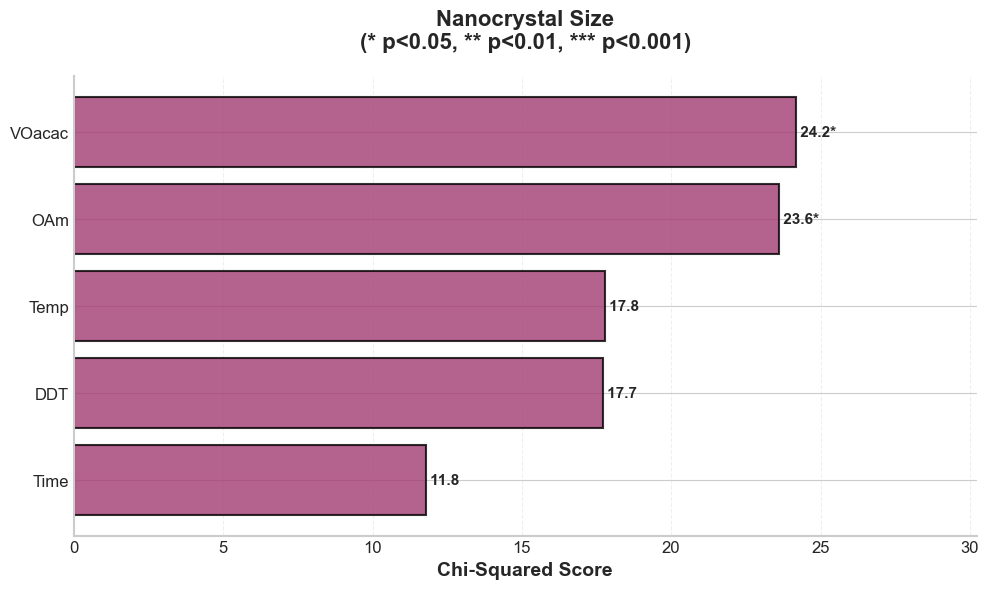


✓ Chi-squared analysis complete
  Significant features (p < 0.05): 2/5

Analyzing: GSD (Chi-squared)
Using 27 samples (filtered to cubic)
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/feature_importance_gsd.png


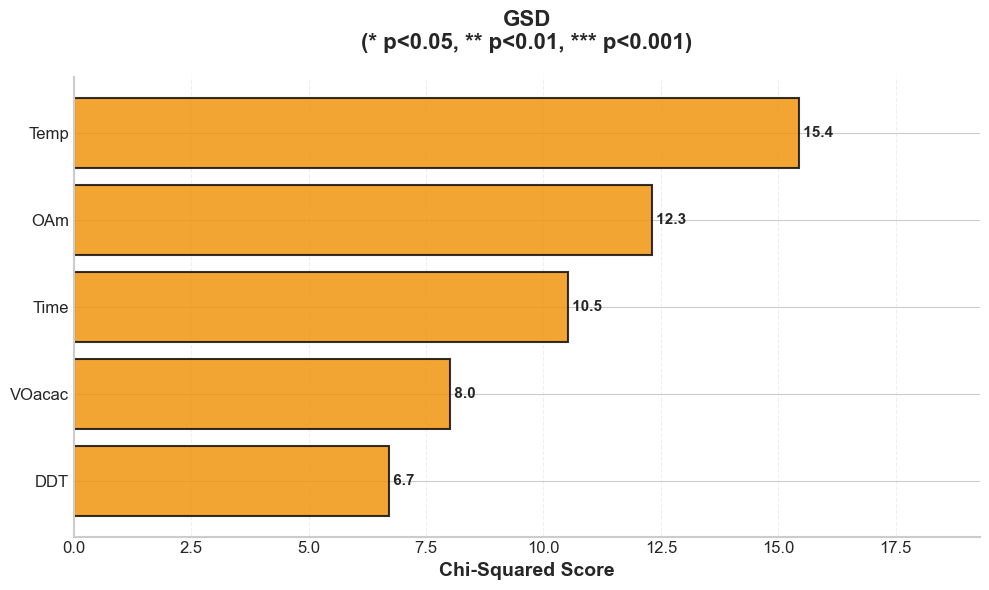


✓ Chi-squared analysis complete
  Significant features (p < 0.05): 0/5

Analyzing: Squareness (Chi-squared)
Using 27 samples (filtered to cubic)
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/feature_importance_squareness.png


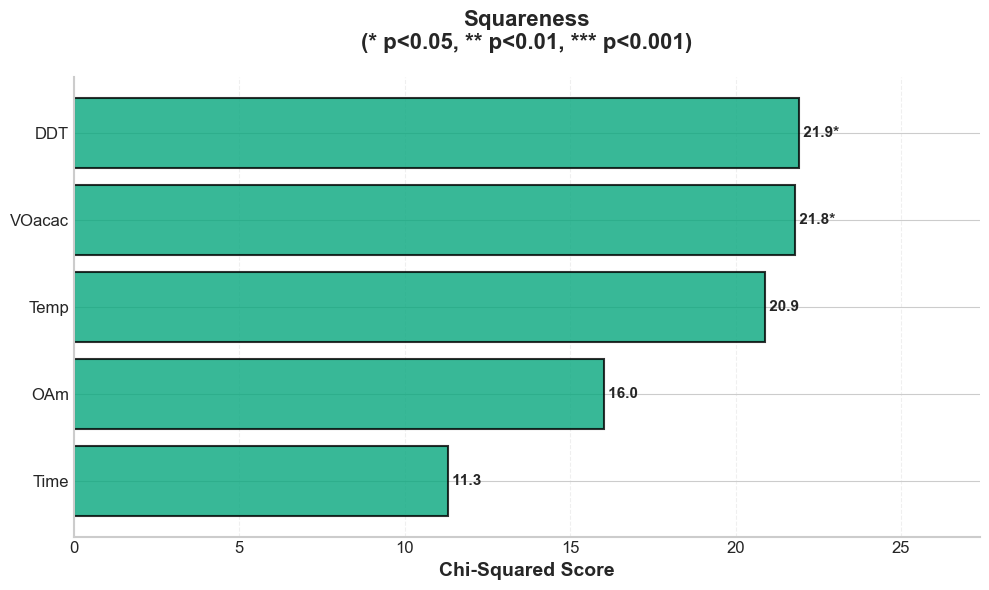


✓ Chi-squared analysis complete
  Significant features (p < 0.05): 2/5

----------------------------------------------------------------------
CATEGORICAL OUTPUTS (Chi-squared)
----------------------------------------------------------------------

Analyzing: Phase Purity (Chi-squared)
Using 31 samples (all with product)
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/feature_importance_phase_purity.png


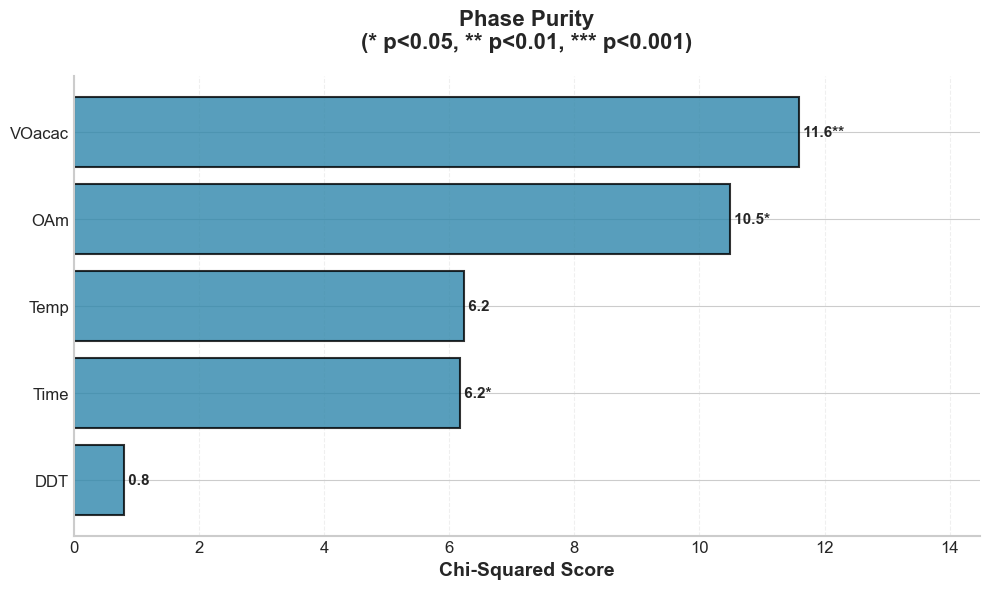


✓ Chi-squared analysis complete
  Significant features (p < 0.05): 3/5

Analyzing: Polymorph (Chi-squared)
Using 31 samples (all with product)
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/feature_importance_polymorph.png


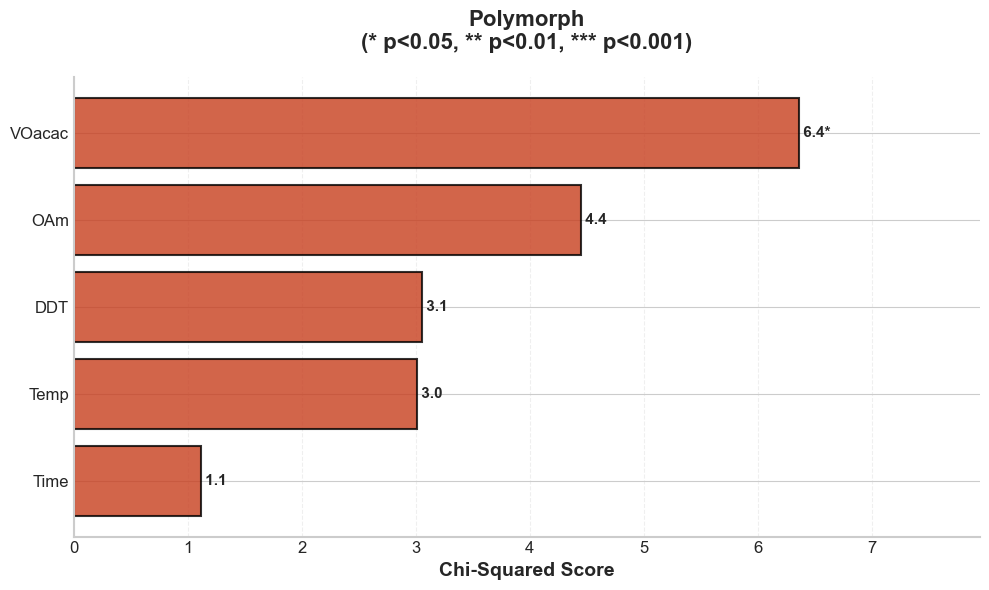


✓ Chi-squared analysis complete
  Significant features (p < 0.05): 1/5

----------------------------------------------------------------------
PRODUCT FORMATION (Chi-squared)
----------------------------------------------------------------------

Analyzing: Product Formation (Chi-squared)
Using 41 samples (all experiments)
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/feature_importance_product_formation.png


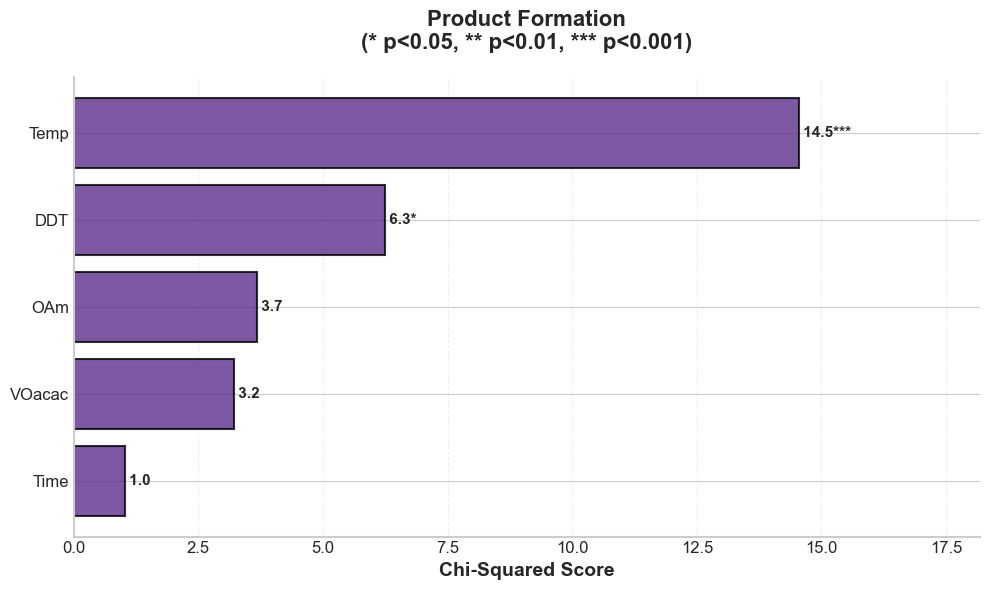


✓ Chi-squared analysis complete
  Significant features (p < 0.05): 2/5

----------------------------------------------------------------------
COMBINED VISUALIZATIONS
----------------------------------------------------------------------

Creating Association Strength Heatmap (Cramér's V)
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/feature_importance_heatmap.png


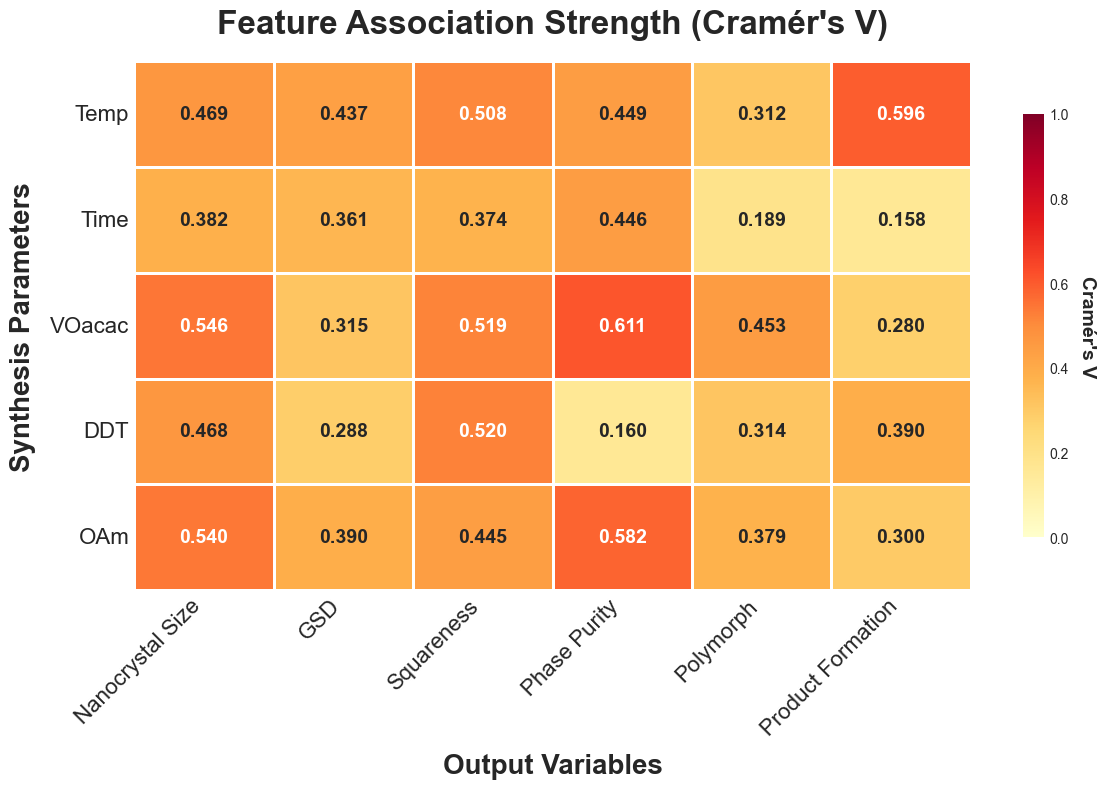

✓ Heatmap displayed

✓ FEATURE IMPORTANCE ANALYSIS COMPLETE!
Analyzed 6 outputs

Summary Table:


,Output,Method,Top_1,Top_2,Top_3
0,Nanocrystal Size,Chi-squared,VOacac (χ²=24.2*),OAm (χ²=23.6*),Temp (χ²=17.8)
1,GSD,Chi-squared,Temp (χ²=15.4),OAm (χ²=12.3),Time (χ²=10.5)
2,Squareness,Chi-squared,DDT (χ²=21.9*),VOacac (χ²=21.8*),Temp (χ²=20.9)
3,Phase Purity,Chi-squared,VOacac (χ²=11.6**),OAm (χ²=10.5*),Temp (χ²=6.2)
4,Polymorph,Chi-squared,VOacac (χ²=6.4*),OAm (χ²=4.4),DDT (χ²=3.1)
5,Product Formation,Chi-squared,Temp (χ²=14.5***),DDT (χ²=6.3*),OAm (χ²=3.7)


In [162]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS CONFIGURATION
# =============================================================================

# Continuous outputs (use Chi-squared with discretization)
CONTINUOUS_OUTPUTS = {
    'Size': {
        'filter': 'cubic',
        'color': '#A23B72',  # Magenta/pink
        'full_name': 'Nanocrystal Size'
    },
    'GSD': {
        'filter': 'cubic',
        'color': '#F18F01',  # Orange
        'full_name': 'GSD'
    },
    'Squareness': {
        'filter': 'cubic',
        'color': '#06A77D',  # Teal/green
        'full_name': 'Squareness'
    }
}

# Categorical outputs (use Chi-squared)
CATEGORICAL_OUTPUTS = {
    'PhasePure': {
        'filter': None,
        'color': '#2E86AB',  # Blue
        'full_name': 'Phase Purity'
    },
    'Polymorph': {
        'filter': None,
        'color': '#C73E1D',  # Red/orange
        'full_name': 'Polymorph'
    }
}

# Product formation analysis
ANALYZE_PRODUCT_FORMATION = True
PRODUCT_COLUMN = 'HasProduct'

print("✓ Feature importance configuration set")
print(f"  Continuous outputs: {list(CONTINUOUS_OUTPUTS.keys())}")
print(f"  Categorical outputs: {list(CATEGORICAL_OUTPUTS.keys())}")
print(f"  Product formation: {ANALYZE_PRODUCT_FORMATION}")

# =============================================================================
# RUN FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("RUNNING FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Create analyzer with full dataset (we'll filter within each analysis)
importance_analyzer = ImportanceAnalyzer(df, FACTORS, n_bins=5)

# Analyze continuous outputs (Chi-squared with discretization)
print("\n" + "-"*70)
print("CONTINUOUS OUTPUTS (Chi-squared)")
print("-"*70)
for output_name, config in CONTINUOUS_OUTPUTS.items():
    if output_name in df.columns:
        importance_analyzer.analyze_continuous_output(output_name, config)
    else:
        print(f"\n⚠ Warning: Column '{output_name}' not found. Skipping.")

# Analyze categorical outputs (Chi-squared)
print("\n" + "-"*70)
print("CATEGORICAL OUTPUTS (Chi-squared)")
print("-"*70)
for output_name, config in CATEGORICAL_OUTPUTS.items():
    if output_name in df.columns:
        importance_analyzer.analyze_categorical_output(output_name, config)
    else:
        print(f"\n⚠ Warning: Column '{output_name}' not found. Skipping.")

# Analyze product formation (Chi-squared)
if ANALYZE_PRODUCT_FORMATION:
    print("\n" + "-"*70)
    print("PRODUCT FORMATION (Chi-squared)")
    print("-"*70)
    importance_analyzer.analyze_product_formation(PRODUCT_COLUMN)

# Create combined visualizations
print("\n" + "-"*70)
print("COMBINED VISUALIZATIONS")
print("-"*70)
heatmap_data = importance_analyzer.create_heatmap()
summary_table = importance_analyzer.create_summary_table()

print("\n" + "="*70)
print("✓ FEATURE IMPORTANCE ANALYSIS COMPLETE!")
print("="*70)
print(f"Analyzed {len(importance_analyzer.results)} outputs")
print("\nSummary Table:")
display(summary_table)

Available in importance_analyzer.results:
  - Nanocrystal Size
  - GSD
  - Squareness
  - Phase Purity
  - Polymorph
  - Product Formation
GENERATING IMPORTANCE-BASED 4D RESPONSE SURFACES
Using 27 cubic samples

----------------------------------------------------------------------
Processing: Size (Nanocrystal Size)
----------------------------------------------------------------------
  Top 3 features for Nanocrystal Size:
    1. VOacac: χ²=24.2, V=nan
    2. OAm: χ²=23.6, V=nan
    3. Temp: χ²=17.8, V=nan

  Creating cube with axes: VOacac × OAm × Temp
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/smooth_cube_Size_importance_based.png


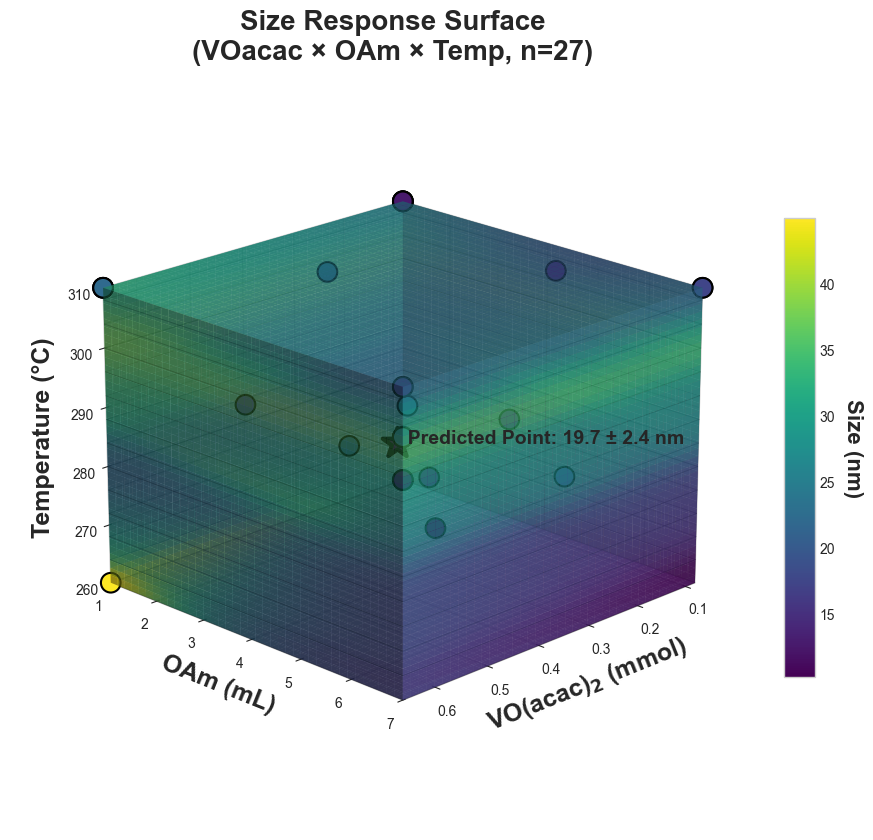

----------------------------------------------------------------------
Processing: GSD (GSD)
----------------------------------------------------------------------
  Top 3 features for GSD:
    1. Temp: χ²=15.4, V=nan
    2. OAm: χ²=12.3, V=nan
    3. Time: χ²=10.5, V=nan

  Creating cube with axes: Temp × OAm × Time
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/smooth_cube_GSD_importance_based.png


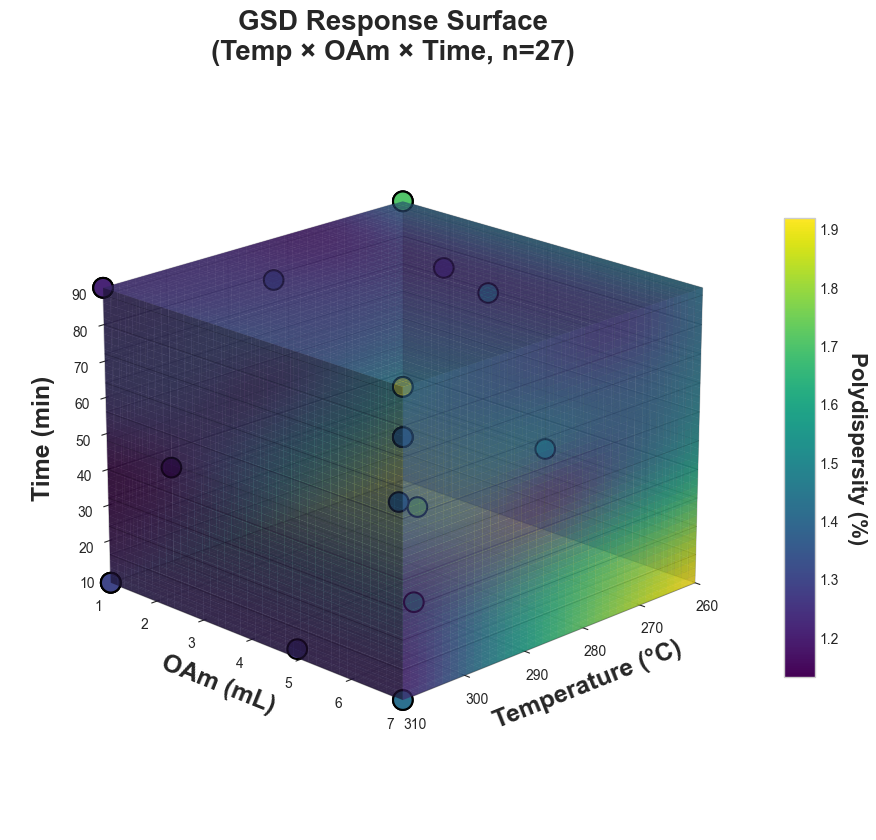

----------------------------------------------------------------------
Processing: Squareness (Squareness)
----------------------------------------------------------------------
  Top 3 features for Squareness:
    1. DDT: χ²=21.9, V=nan
    2. VOacac: χ²=21.8, V=nan
    3. Temp: χ²=20.9, V=nan

  Creating cube with axes: DDT × VOacac × Temp
✓ Saved: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/smooth_cube_Squareness_importance_based.png


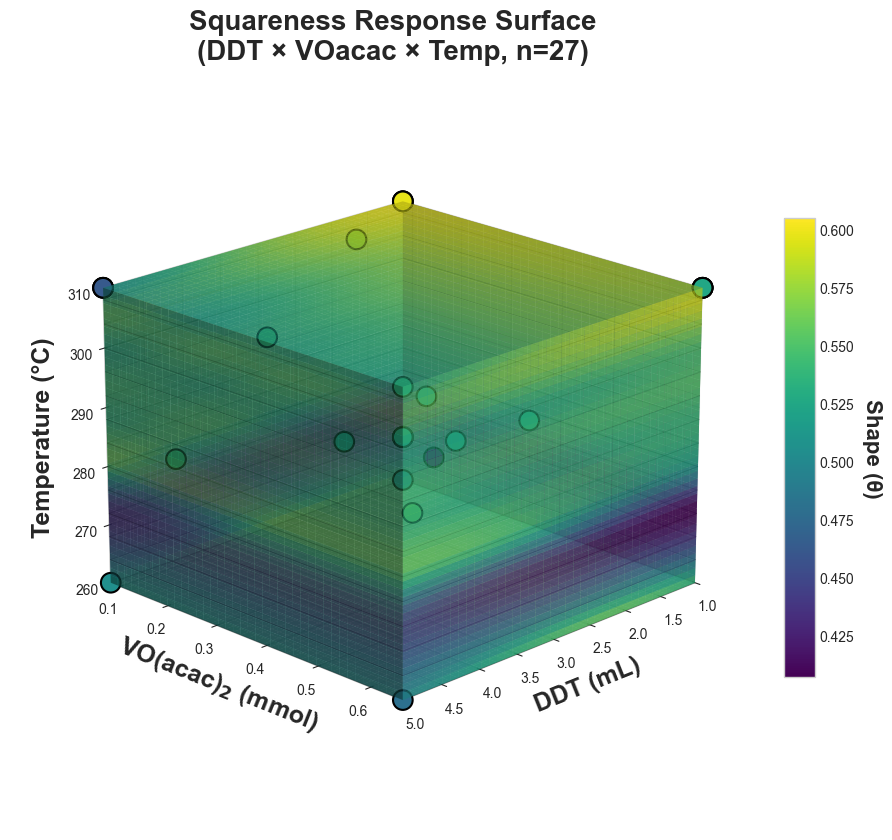


✓ IMPORTANCE-BASED RESPONSE SURFACES COMPLETE!

Summary of generated surfaces:
  Size: VOacac × OAm × Temp
  GSD: Temp × OAm × Time
  Squareness: DDT × VOacac × Temp


In [163]:
# Define mapping from your response columns to analyzer result names
OUTPUT_MAPPING = {
    'Size': 'Nanocrystal Size',
    'GSD': 'GSD',
    'Squareness': 'Squareness'
}

# Check what names are actually in your results
print("Available in importance_analyzer.results:")
for name in importance_analyzer.results.keys():
    print(f"  - {name}")

# Optional: Add custom points to specific graphs
custom_points_dict = {
    'Size': [
        {
            'x': 0.594,  # VOacac
            'y': 6.2,    # OAm
            'z': 297,    # Temp
            'label': 'Predicted Point',
            'marker': '*',
            'size': 500,
            'predicted_value': 19.7,  # Your predicted size from the model
            'predicted_std': 2.4      # Your uncertainty from the model
        }
    ]
}

# Generate surfaces using top 3 features per response
results = generate_importance_based_response_surfaces(
    df=df,
    importance_analyzer=importance_analyzer,
    output_mapping=OUTPUT_MAPPING,
    filter_cubic=True,
    elev=20,
    azim=45,
    save_func=save_figure,
    custom_points=custom_points_dict,
    # Font size controls:
    fontsize_title=20,          # Title (default: 14)
    fontsize_labels=18,         # X, Y, Z axis labels (default: 12)
    fontsize_cbar=16,           # Colorbar label (default: 11)
    fontsize_point_labels=14    # Point labels (default: 10)
)

## Predictor Class

In [164]:
class Cu3VS4_Predictor:
    """
    Simple predictor for Cu₃VS₄ nanoparticle synthesis outcomes.
    Trains Random Forest models for GSD, Size, and Squareness.
    """
    
    def __init__(self, data, factors=['Temp', 'Time', 'VOacac', 'DDT', 'OAm'],
                 responses=['GSD', 'Size', 'Squareness'], filter_cubic=True):
        """
        Initialize and train the predictor.
        
        Parameters:
        -----------
        data : pd.DataFrame
            Your experimental data (df from the notebook)
        factors : list
            Input features (reaction conditions)
        responses : list
            Output targets to predict
        filter_cubic : bool
            Whether to filter to cubic polymorph only
        """
        self.factors = factors
        self.responses = responses
        self.models = {}
        self.scalers = {}
        self.bounds = {}
        
        # Prepare data
        df_work = data.copy()
        if filter_cubic and 'Polymorph' in df_work.columns:
            df_work = df_work[(df_work['HasProduct'] == 1) & (df_work['Polymorph'] == 'cubic')]
        
        # Store factor bounds for validation
        for factor in factors:
            self.bounds[factor] = (df_work[factor].min(), df_work[factor].max())
        
        # Train a model for each response
        print("Training predictors...")
        for response in responses:
            subset = df_work.dropna(subset=[response] + factors)
            
            if len(subset) < 5:
                print(f"  ⚠ Skipping {response}: insufficient data ({len(subset)} samples)")
                continue
            
            X = subset[factors].values
            y = subset[response].values
            
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=None,
                min_samples_leaf=2,
                random_state=42
            )
            model.fit(X_scaled, y)
            
            self.models[response] = model
            self.scalers[response] = scaler
            
            train_score = model.score(X_scaled, y)
            print(f"  ✓ {response}: trained on {len(subset)} samples (R² = {train_score:.3f})")
        
        print(f"\n✓ Predictor ready!")
    
    def predict(self, Temp=285, Time=49, VOacac=0.37, DDT=3.0, OAm=4.0):
        """
        Predict synthesis outcomes for given reaction conditions.
        
        Parameters:
        -----------
        Temp : float - Temperature (°C), typically 260-310
        Time : float - Reaction time (min), typically 8-90
        VOacac : float - VO(acac)₂ amount (mmol), typically 0.08-0.66
        DDT : float - DDT amount (mL), typically 1-5
        OAm : float - Oleylamine amount (mL), typically 1-7
        
        Returns:
        --------
        dict with predicted GSD, Size, Squareness
        """
        X = np.array([[Temp, Time, VOacac, DDT, OAm]])
        
        # Check bounds
        for i, (factor, val) in enumerate(zip(self.factors, X[0])):
            low, high = self.bounds[factor]
            if val < low or val > high:
                print(f"⚠ {factor}={val:.2f} outside training range [{low:.2f}, {high:.2f}]")
        
        predictions = {'Temp': Temp, 'Time': Time, 'VOacac': VOacac, 
                       'DDT': DDT, 'OAm': OAm}
        
        for response in self.responses:
            if response in self.models:
                X_scaled = self.scalers[response].transform(X)
                pred = self.models[response].predict(X_scaled)[0]
                predictions[response] = round(pred, 4)
            else:
                predictions[response] = None
        
        return predictions
    
    def predict_batch(self, conditions_df):
        """Predict for multiple conditions at once."""
        results = conditions_df.copy()
        
        for response in self.responses:
            if response in self.models:
                X = conditions_df[self.factors].values
                X_scaled = self.scalers[response].transform(X)
                results[f'{response}_pred'] = self.models[response].predict(X_scaled)
        
        return results

print("✓ Cu3VS4_Predictor class defined")

✓ Cu3VS4_Predictor class defined


## Initialize Predictor

In [165]:
# Train the predictor on your data
predictor = Cu3VS4_Predictor(df)

Training predictors...
  ✓ GSD: trained on 27 samples (R² = 0.601)
  ✓ Size: trained on 27 samples (R² = 0.678)
  ✓ Squareness: trained on 27 samples (R² = 0.571)

✓ Predictor ready!


## Predictor Execution

In [166]:
# Single prediction - just pass the reaction conditions
result = predictor.predict(
    Temp=297,
    Time=14,
    VOacac=0.594,
    DDT=2.3,
    OAm=6.2
)

print("Predicted outcomes:")
print(f"  GSD: {result['GSD']}")
print(f"  Size: {result['Size']} nm")
print(f"  Squareness: {result['Squareness']}")

Predicted outcomes:
  GSD: 1.4679
  Size: 19.2122 nm
  Squareness: 0.5275


## Export Results

In [167]:
# Save importance summary
if importance_analyzer.results:
    summary_data = []
    for output_name, result in importance_analyzer.results.items():
        imp_df = result['dataframe']
        method = result.get('method', 'Unknown')
        for _, row in imp_df.iterrows():
            entry = {
                'Response': output_name,
                'Feature': row.get('Feature', row.get('Term')),
                'Importance': row['ChiSquared'],
                'Method': method
            }
            # Add chi-squared info if available
            if 'chi2_scores' in result:
                feat_idx = list(FACTORS).index(row['Feature'])
                entry['Chi2_Score'] = result['chi2_scores'][feat_idx]
                entry['P_Value'] = result['p_values'][feat_idx]
            summary_data.append(entry)

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(os.path.join(OUTPUT_PATH, 'importance_summary.csv'), index=False)
    print(f"✓ Saved {OUTPUT_PATH}/importance_summary.csv")

    display(summary_df)

✓ Saved /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs/importance_summary.csv


,Response,Feature,Importance,Method
0,Nanocrystal Size,Time,11.800909,Chi-squared
1,Nanocrystal Size,DDT,17.720455,Chi-squared
2,Nanocrystal Size,Temp,17.790000,Chi-squared
3,Nanocrystal Size,OAm,23.611364,Chi-squared
4,Nanocrystal Size,VOacac,24.181169,Chi-squared
5,GSD,DDT,6.715909,Chi-squared
6,GSD,VOacac,8.020130,Chi-squared
7,GSD,Time,10.527273,Chi-squared
8,GSD,OAm,12.306818,Chi-squared
9,GSD,Temp,15.436364,Chi-squared


In [168]:
print("\n" + "="*70)
print("✓ ANALYSIS COMPLETE")
print("="*70)


✓ ANALYSIS COMPLETE
